# GNN Project - predicting new links 

## Imports

In [140]:
# === Standard Libraries ===
import os
import json
import time
import random
from collections import defaultdict, Counter
import seaborn as sns
from scipy.stats import entropy

# === Data & Plotting ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === PyTorch & PyTorch Geometric ===
import torch
import torch.nn.functional as F
from torch.nn import Linear, Module, BCEWithLogitsLoss
from torch.optim import Adam

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, TransformerConv

# === Transformers & Embeddings ===
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer

# === Sklearn ===
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    classification_report,
    roc_curve,
    auc
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA

# === Graph Libraries ===
import networkx as nx
from networkx.algorithms import bipartite

# === Progress Bar ===
from tqdm import tqdm


### The Data

In [19]:
base_path = r"C:/Users/adamb/Desktop/works/MSC/סמסטר ב/למידה עמוקה למתקדמים/Data/archive"
train_path = os.path.join(base_path, "TBGA_train.txt")
val_path = os.path.join(base_path, "TBGA_val.txt")
test_path = os.path.join(base_path, "TBGA_test.txt")


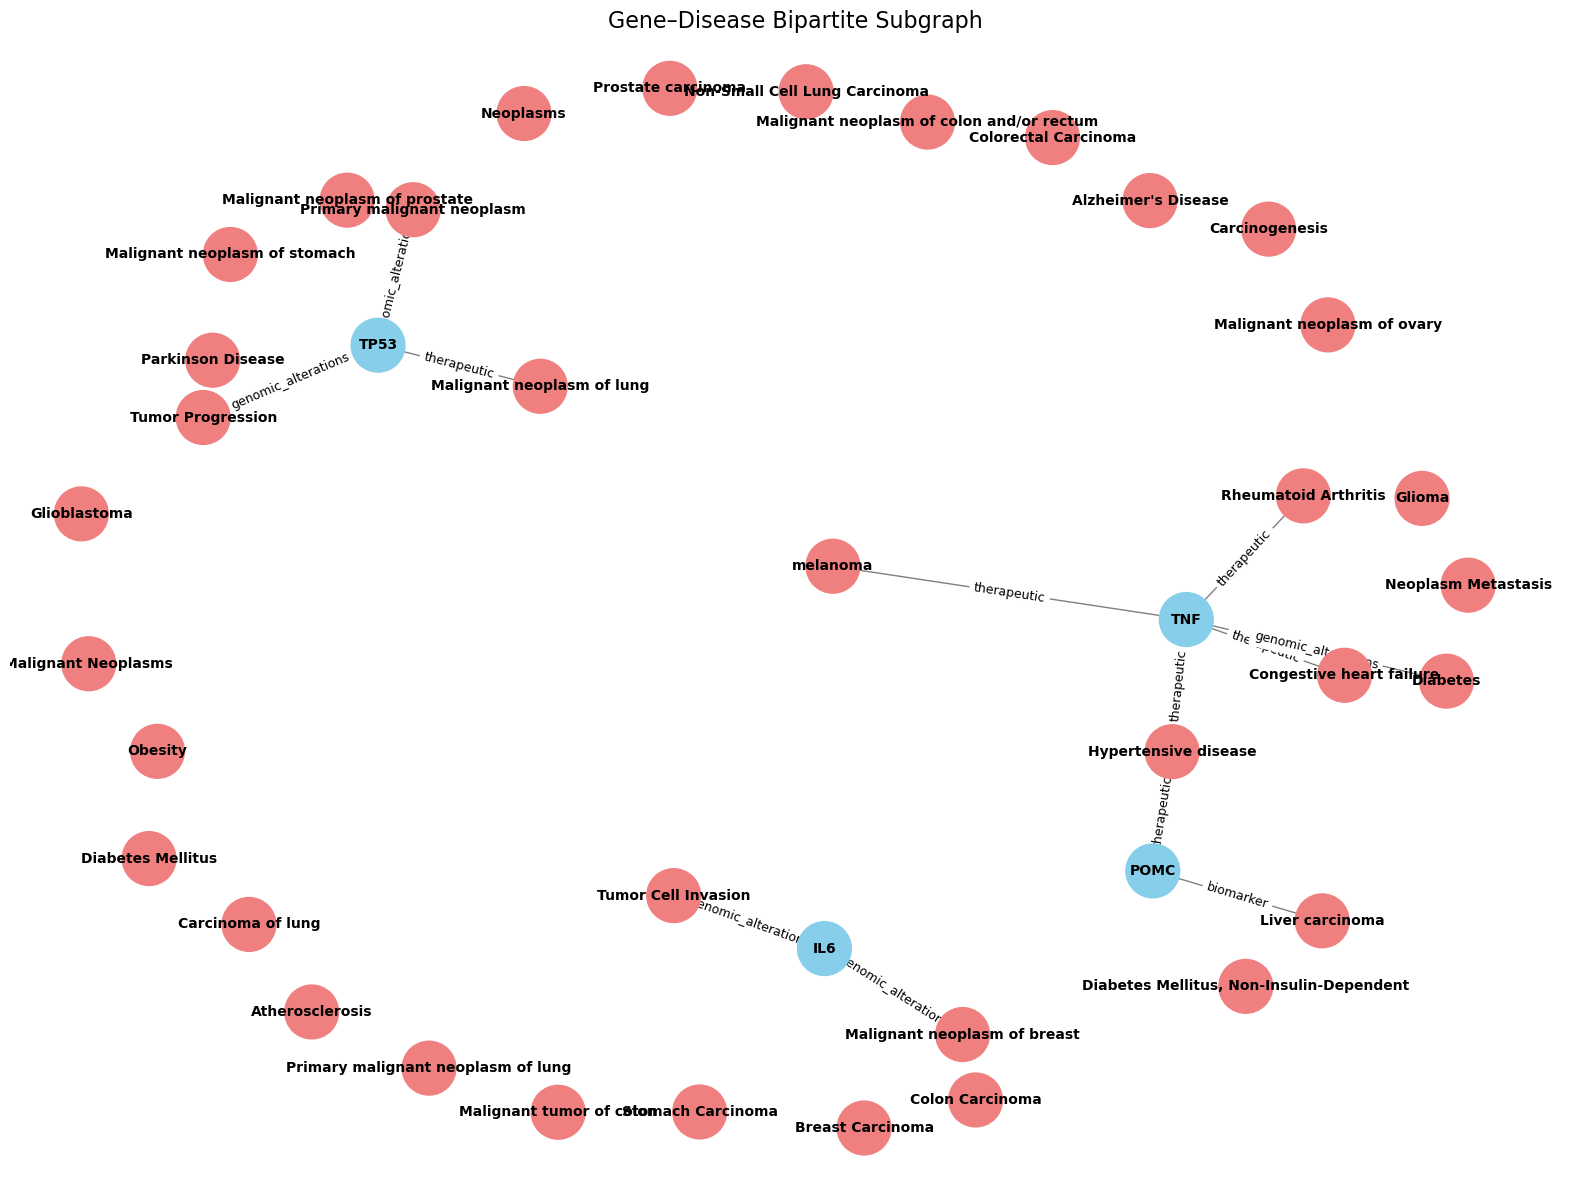

In [20]:
# === Relation mapping (multi-class, no "NA") ===
relation2id = {
    "therapeutic": 0,
    "biomarker": 1,
    "genomic_alterations": 2
}


# === Load edges and text descriptions ===
def extract_edges_and_texts(jsonl_path, keep_na=False):
    edges = []
    gene_texts = defaultdict(list)
    disease_texts = defaultdict(list)

    with open(jsonl_path, 'r') as f:
        for line in f:
            entry = json.loads(line.strip())
            text = entry["text"]
            gene_id = f"G_{entry['h']['id']}"
            disease_id = f"D_{entry['t']['id']}"

            # Always collect text for embedding (even if relation is NA)
            gene_texts[gene_id].append(text)
            disease_texts[disease_id].append(text)

            if not keep_na and entry["relation"] == "NA":
                continue  # skip from graph construction

            if entry["relation"] != "NA":
                edges.append({
                    "gene_id": gene_id,
                    "gene_name": entry["h"]["name"],
                    "disease_id": disease_id,
                    "disease_name": entry["t"]["name"],
                    "relation": entry["relation"],
                    "relation_id": relation2id[entry["relation"]]
                })

    return edges, gene_texts, disease_texts

# === Build bipartite graph from labeled edges ===
def build_bipartite_graph(edge_list):
    B = nx.Graph()
    for edge in edge_list:
        gene = edge["gene_id"]
        disease = edge["disease_id"]
        B.add_node(gene, label=edge["gene_name"], type="gene")
        B.add_node(disease, label=edge["disease_name"], type="disease")
        B.add_edge(gene, disease, relation=edge["relation"], relation_id=edge["relation_id"])
    return B

# === Subgraph visualization ===
def visualize_clean_subgraph(G, max_nodes=50, title="Gene–Disease Bipartite Subgraph"):
    top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:max_nodes]
    sub_nodes = [n for n, _ in top_nodes]
    subgraph = G.subgraph(sub_nodes)

    pos = nx.spring_layout(subgraph, k=0.9, iterations=100, seed=42)
    node_colors = ['skyblue' if subgraph.nodes[n]['type'] == 'gene' else 'lightcoral' for n in subgraph.nodes]
    labels = nx.get_node_attributes(subgraph, 'label')
    edge_labels = nx.get_edge_attributes(subgraph, 'relation')

    plt.figure(figsize=(16, 12))
    nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=1500)
    nx.draw_networkx_edges(subgraph, pos, edge_color='gray')
    nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=10, font_weight='bold')
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=9)

    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


# === Load and parse ===
train_edges, train_gene_texts, train_disease_texts = extract_edges_and_texts(train_path, keep_na=False)
val_edges, val_gene_texts, val_disease_texts = extract_edges_and_texts(val_path, keep_na=True)
test_edges, test_gene_texts, test_disease_texts = extract_edges_and_texts(test_path, keep_na=True)

# === Combine all node texts (for embeddings) ===
all_gene_texts = defaultdict(list)
all_disease_texts = defaultdict(list)

for d in [train_gene_texts, val_gene_texts, test_gene_texts]:
    for k, v in d.items():
        all_gene_texts[k].extend(v)

for d in [train_disease_texts, val_disease_texts, test_disease_texts]:
    for k, v in d.items():
        all_disease_texts[k].extend(v)

# === Build training graph (only labeled edges) ===
train_graph = build_bipartite_graph(train_edges)

# === Visualize small subgraph ===
visualize_clean_subgraph(train_graph, max_nodes=40)

In [126]:
# Remove isolated nodes (no connections)
isolated = list(nx.isolates(train_graph))
print(f"Removing {len(isolated)} isolated nodes...")
train_graph.remove_nodes_from(isolated)


Removing 0 isolated nodes...


Some of those sub_nodes may actually be isolated within the subgraph, even if they’re not in the full graph!


## EDA

Let's explore the data:

In [136]:
def print_basic_stats(edges):
    print(f"Total labeled edges: {len(edges)}")
    relation_counts = Counter([e["relation"] for e in edges])
    print("Relation distribution:")
    for rel, count in relation_counts.items():
        print(f"  {rel}: {count}")

def count_unique_nodes(edges):
    gene_ids = set(e["gene_id"] for e in edges)
    disease_ids = set(e["disease_id"] for e in edges)
    print(f"Unique genes: {len(gene_ids)}")
    print(f"Unique diseases: {len(disease_ids)}")

print("=== TRAIN STATS ===")
print_basic_stats(train_edges)
count_unique_nodes(train_edges)

=== TRAIN STATS ===
Total labeled edges: 56115
Relation distribution:
  genomic_alterations: 32831
  biomarker: 20145
  therapeutic: 3139
Unique genes: 7925
Unique diseases: 5666


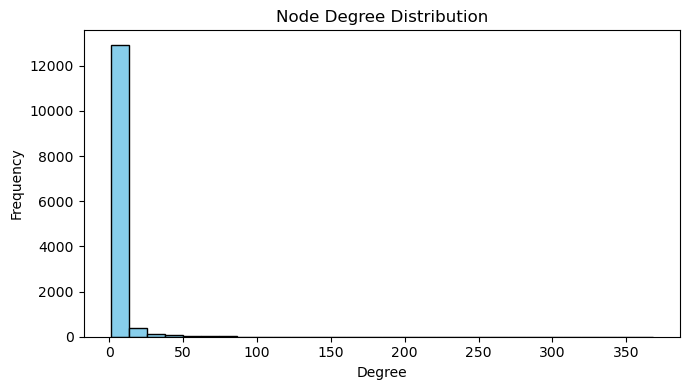

In [139]:
def plot_degree_distribution(G):
    degrees = [d for _, d in G.degree()]
    plt.figure(figsize=(7, 4))
    plt.hist(degrees, bins=30, color='skyblue', edgecolor='black')
    plt.title("Node Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_degree_distribution(train_graph)


In [22]:
def print_top_nodes_by_degree(G, node_type, top_n=10):
    filtered_nodes = [(n, G.degree(n)) for n in G.nodes if G.nodes[n]['type'] == node_type]
    top = sorted(filtered_nodes, key=lambda x: x[1], reverse=True)[:top_n]
    print(f"Top {node_type}s by degree:")
    for nid, deg in top:
        print(f"  {G.nodes[nid]['label']} (ID: {nid}) — degree {deg}")

print_top_nodes_by_degree(train_graph, "gene")
print_top_nodes_by_degree(train_graph, "disease")

Top genes by degree:
  TNF (ID: G_7124) — degree 119
  TP53 (ID: G_7157) — degree 103
  IL6 (ID: G_3569) — degree 90
  POMC (ID: G_5443) — degree 82
  IFNG (ID: G_3458) — degree 73
  BDNF (ID: G_627) — degree 67
  IL10 (ID: G_3586) — degree 67
  EGFR (ID: G_1956) — degree 66
  TGFB1 (ID: G_7040) — degree 66
  VEGFA (ID: G_7422) — degree 61
Top diseases by degree:
  Neoplasms (ID: D_C0027651) — degree 368
  Primary malignant neoplasm (ID: D_C1306459) — degree 305
  Malignant Neoplasms (ID: D_C0006826) — degree 291
  Breast Carcinoma (ID: D_C0678222) — degree 233
  Carcinogenesis (ID: D_C0596263) — degree 224
  Malignant neoplasm of breast (ID: D_C0006142) — degree 211
  Neoplasm Metastasis (ID: D_C0027627) — degree 193
  Tumor Cell Invasion (ID: D_C1269955) — degree 172
  Liver carcinoma (ID: D_C2239176) — degree 154
  Colorectal Carcinoma (ID: D_C0009402) — degree 150


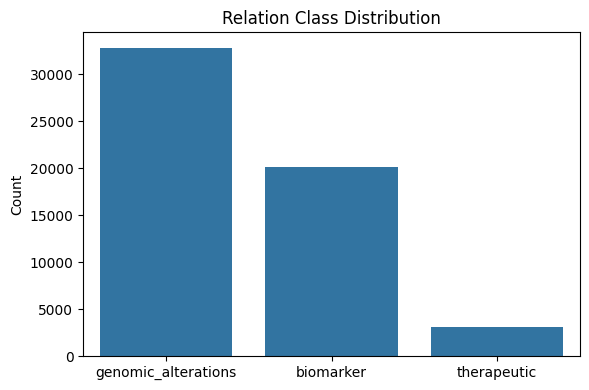

In [23]:
def plot_relation_balance(edges):
    relation_counts = Counter(e["relation"] for e in edges)
    labels, values = zip(*relation_counts.items())

    plt.figure(figsize=(6, 4))
    sns.barplot(x=list(labels), y=list(values))
    plt.title("Relation Class Distribution")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

plot_relation_balance(train_edges)

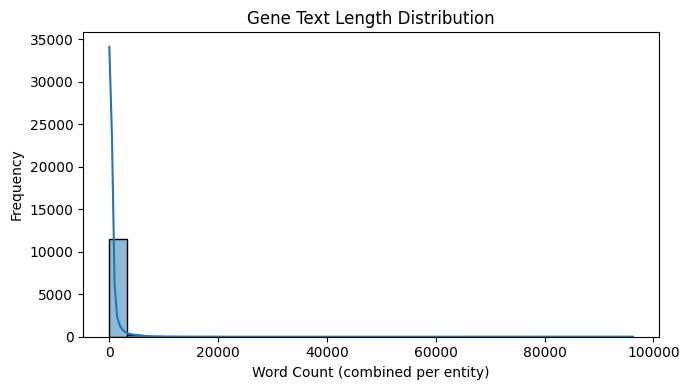

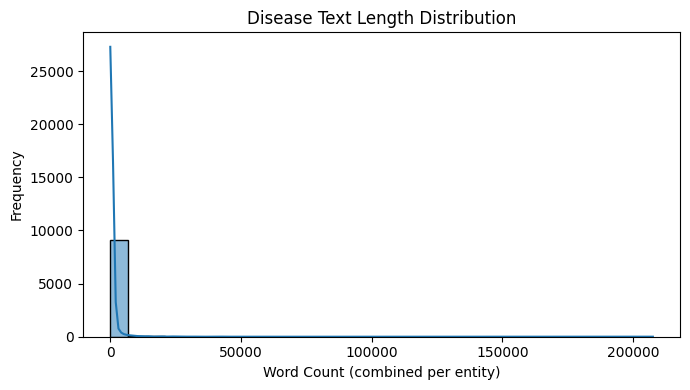

In [24]:
def plot_text_length_distribution(texts_dict, entity_type):
    lengths = [len(" ".join(texts).split()) for texts in texts_dict.values()]
    plt.figure(figsize=(7, 4))
    sns.histplot(lengths, bins=30, kde=True)
    plt.title(f"{entity_type} Text Length Distribution")
    plt.xlabel("Word Count (combined per entity)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_text_length_distribution(all_gene_texts, "Gene")
plot_text_length_distribution(all_disease_texts, "Disease")

In [25]:
def edge_signature(e):
    return (e["gene_id"], e["disease_id"])

def compute_edge_overlap(set1, set2):
    s1 = set(edge_signature(e) for e in set1)
    s2 = set(edge_signature(e) for e in set2)
    overlap = s1 & s2
    return len(overlap), len(overlap) / len(s2)

print("=== Edge Overlaps ===")
overlap_tv, frac_tv = compute_edge_overlap(train_edges, val_edges)
print(f"Train ↔︎ Val: {overlap_tv} edges ({frac_tv:.1%})")

overlap_tt, frac_tt = compute_edge_overlap(train_edges, test_edges)
print(f"Train ↔︎ Test: {overlap_tt} edges ({frac_tt:.1%})")

overlap_vt, frac_vt = compute_edge_overlap(val_edges, test_edges)
print(f"Val ↔︎ Test: {overlap_vt} edges ({frac_vt:.1%})")

=== Edge Overlaps ===
Train ↔︎ Val: 0 edges (0.0%)
Train ↔︎ Test: 0 edges (0.0%)
Val ↔︎ Test: 0 edges (0.0%)


Total connected components: 283
Largest component size: 12987


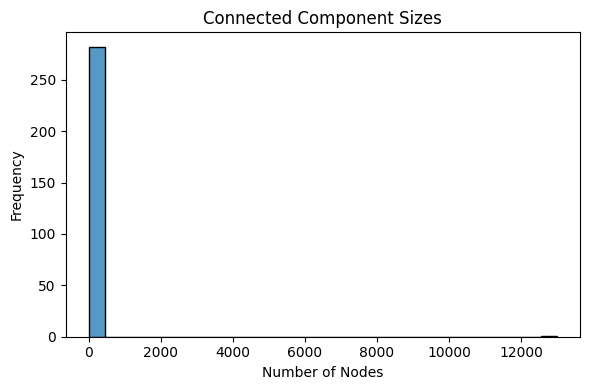

In [26]:
def analyze_components(G):
    comps = list(nx.connected_components(G))
    comp_sizes = [len(c) for c in comps]

    print(f"Total connected components: {len(comps)}")
    print(f"Largest component size: {max(comp_sizes)}")

    plt.figure(figsize=(6, 4))
    sns.histplot(comp_sizes, bins=30)
    plt.title("Connected Component Sizes")
    plt.xlabel("Number of Nodes")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

analyze_components(train_graph)

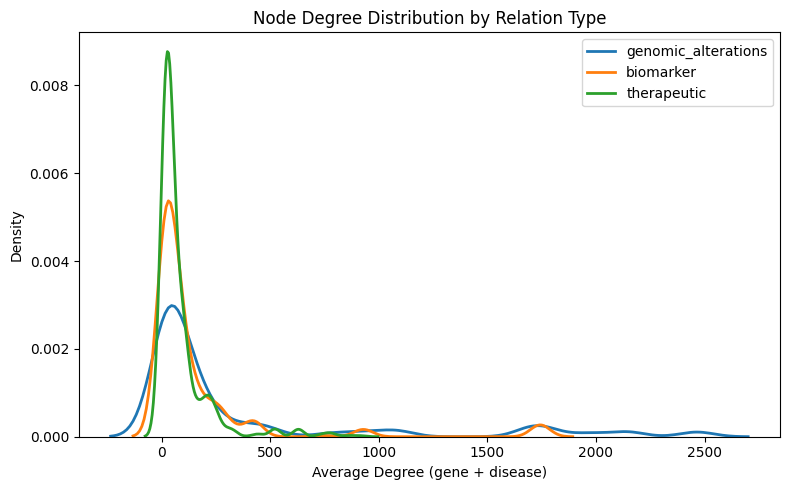

In [27]:
def plot_relation_vs_degree(edges):
    deg_map = defaultdict(int)
    for e in edges:
        deg_map[e["gene_id"]] += 1
        deg_map[e["disease_id"]] += 1

    relation_degrees = defaultdict(list)
    for e in edges:
        d1 = deg_map[e["gene_id"]]
        d2 = deg_map[e["disease_id"]]
        relation_degrees[e["relation"]].append((d1 + d2) / 2)

    plt.figure(figsize=(8, 5))
    for rel, degrees in relation_degrees.items():
        sns.kdeplot(degrees, label=rel, linewidth=2)

    plt.title("Node Degree Distribution by Relation Type")
    plt.xlabel("Average Degree (gene + disease)")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_relation_vs_degree(train_edges)


In [28]:
def compute_text_duplication(texts_dict, entity_type):
    all_texts = [" ".join(t) for t in texts_dict.values()]
    total = len(all_texts)
    unique = len(set(all_texts))
    dup_fraction = 1 - unique / total

    print(f"{entity_type} text blocks: {total}")
    print(f"Unique text blocks: {unique}")
    print(f"Duplicated fraction: {dup_fraction:.2%}")

compute_text_duplication(all_gene_texts, "Gene")
compute_text_duplication(all_disease_texts, "Disease")

Gene text blocks: 11784
Unique text blocks: 11692
Duplicated fraction: 0.78%
Disease text blocks: 9199
Unique text blocks: 9060
Duplicated fraction: 1.51%


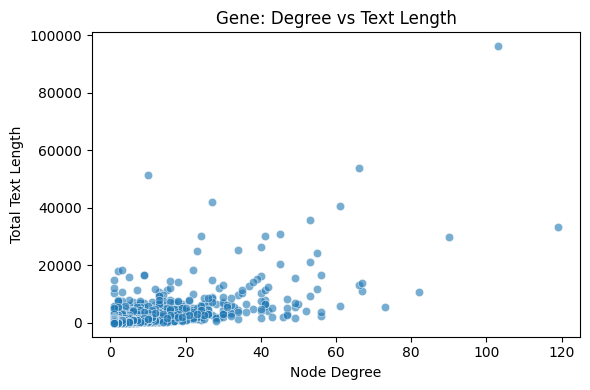

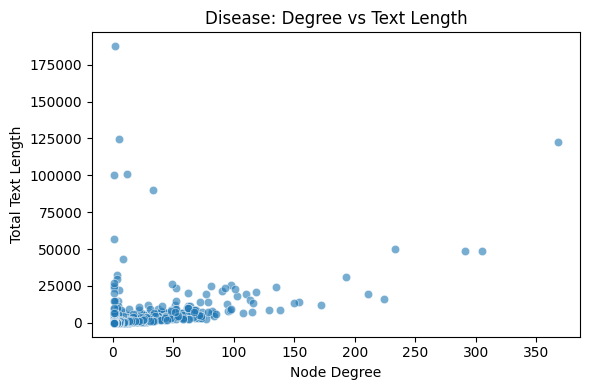

In [29]:
def plot_text_length_vs_degree(G, texts_dict, node_type):
    lengths = []
    degrees = []

    for n in G.nodes:
        if G.nodes[n]["type"] != node_type:
            continue
        if n not in texts_dict:
            continue
        text = " ".join(texts_dict[n])
        lengths.append(len(text.split()))
        degrees.append(G.degree[n])

    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=degrees, y=lengths, alpha=0.6)
    plt.title(f"{node_type.capitalize()}: Degree vs Text Length")
    plt.xlabel("Node Degree")
    plt.ylabel("Total Text Length")
    plt.tight_layout()
    plt.show()

plot_text_length_vs_degree(train_graph, all_gene_texts, "gene")
plot_text_length_vs_degree(train_graph, all_disease_texts, "disease")

In [30]:
def print_graph_density_stats(G):
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    density = nx.density(G)

    print(f"Nodes: {num_nodes}")
    print(f"Edges: {num_edges}")
    print(f"Graph density: {density:.6f} (very low = very sparse)")

print_graph_density_stats(train_graph)

Nodes: 13591
Edges: 28349
Graph density: 0.000307 (very low = very sparse)


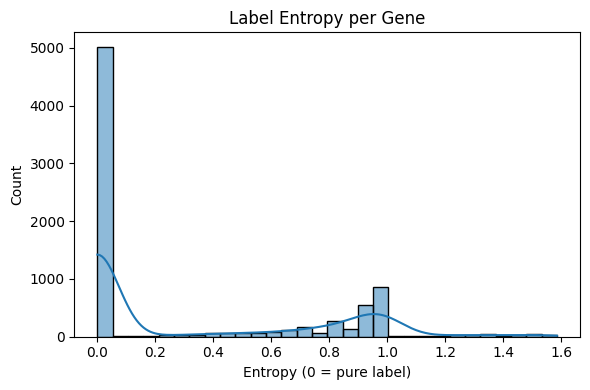

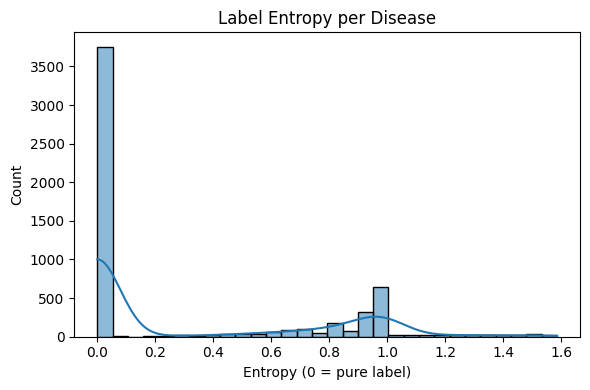

In [31]:
def compute_label_entropy(edges, node_type):
    rel_map = defaultdict(list)
    for e in edges:
        node_id = e["gene_id"] if node_type == "gene" else e["disease_id"]
        rel_map[node_id].append(e["relation"])

    entropies = []
    for rels in rel_map.values():
        counts = Counter(rels)
        probs = np.array(list(counts.values())) / len(rels)
        entropies.append(entropy(probs, base=2))

    plt.figure(figsize=(6, 4))
    sns.histplot(entropies, bins=30, kde=True)
    plt.title(f"Label Entropy per {node_type.capitalize()}")
    plt.xlabel("Entropy (0 = pure label)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

compute_label_entropy(train_edges, "gene")
compute_label_entropy(train_edges, "disease")

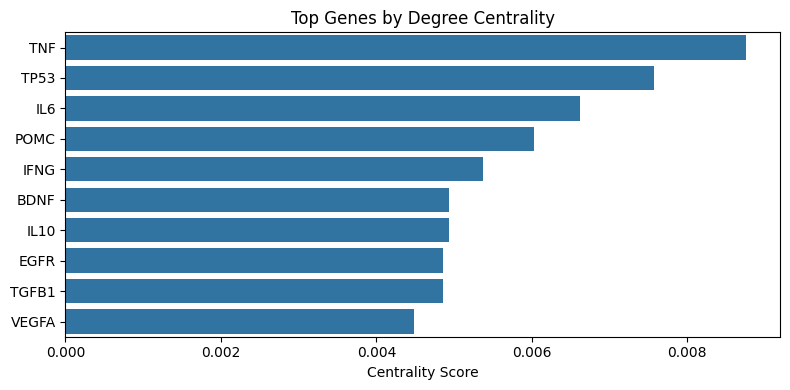

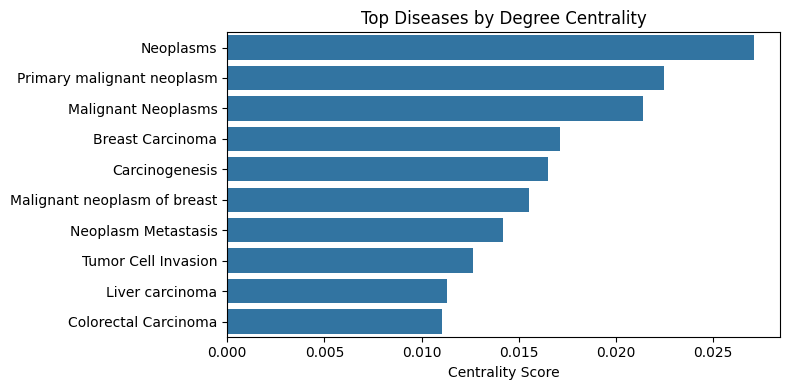

In [32]:
def plot_top_central_nodes(G, node_type, top_n=10):
    sub_nodes = [n for n in G.nodes if G.nodes[n]['type'] == node_type]
    centrality = nx.degree_centrality(G)
    ranked = sorted([(n, centrality[n]) for n in sub_nodes], key=lambda x: x[1], reverse=True)[:top_n]

    names = [G.nodes[n]["label"] for n, _ in ranked]
    scores = [s for _, s in ranked]

    plt.figure(figsize=(8, 4))
    sns.barplot(x=scores, y=names)
    plt.title(f"Top {node_type.capitalize()}s by Degree Centrality")
    plt.xlabel("Centrality Score")
    plt.tight_layout()
    plt.show()

plot_top_central_nodes(train_graph, "gene")
plot_top_central_nodes(train_graph, "disease")

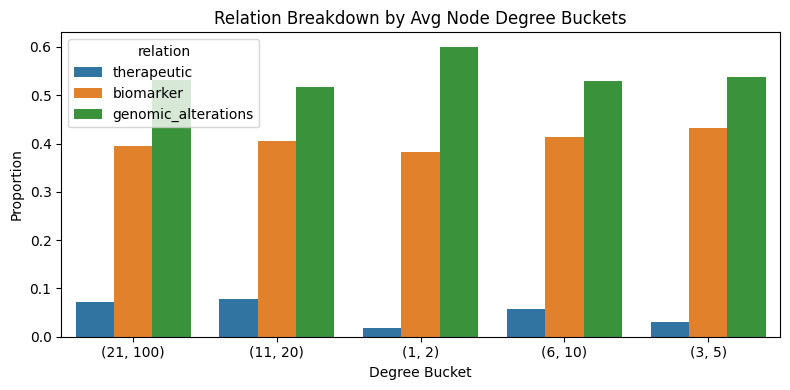

In [34]:
def plot_relation_distribution_by_degree_bucket(edges, buckets=[(1,2), (3,5), (6,10), (11,20), (21, 100)]):
    degree_map = defaultdict(int)
    for e in edges:
        degree_map[e["gene_id"]] += 1
        degree_map[e["disease_id"]] += 1

    bucket_counts = defaultdict(lambda: Counter())
    for e in edges:
        d = (degree_map[e["gene_id"]] + degree_map[e["disease_id"]]) / 2
        for b in buckets:
            if b[0] <= d <= b[1]:
                bucket_counts[str(b)][e["relation"]] += 1
                break

    df = []
    for b, rels in bucket_counts.items():
        total = sum(rels.values())
        for rel in relation2id:
            df.append({"bucket": b, "relation": rel, "pct": rels[rel]/total if total > 0 else 0})

    df = pd.DataFrame(df)

    plt.figure(figsize=(8, 4))
    sns.barplot(data=df, x="bucket", y="pct", hue="relation")
    plt.title("Relation Breakdown by Avg Node Degree Buckets")
    plt.ylabel("Proportion")
    plt.xlabel("Degree Bucket")
    plt.tight_layout()
    plt.show()

plot_relation_distribution_by_degree_bucket(train_edges)

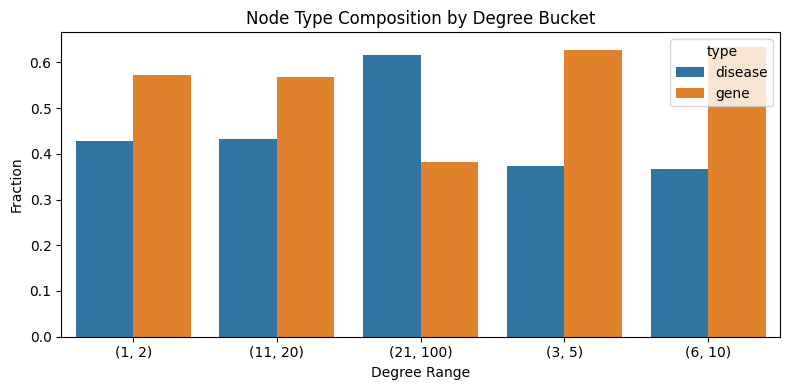

In [40]:
def plot_node_type_ratio_by_degree(G, buckets=[(1,2), (3,5), (6,10), (11,20), (21, 100)]):
    data = []

    for n in G.nodes:
        deg = G.degree[n]
        node_type = G.nodes[n]['type']
        for b in buckets:
            if b[0] <= deg <= b[1]:
                data.append({"bucket": str(b), "type": node_type})
                break

    df = pd.DataFrame(data)
    ratio = df.groupby(["bucket", "type"]).size().reset_index(name="count")
    total = ratio.groupby("bucket")["count"].transform("sum")
    ratio["pct"] = ratio["count"] / total

    plt.figure(figsize=(8, 4))
    sns.barplot(data=ratio, x="bucket", y="pct", hue="type")
    plt.title("Node Type Composition by Degree Bucket")
    plt.ylabel("Fraction")
    plt.xlabel("Degree Range")
    plt.tight_layout()
    plt.show()

plot_node_type_ratio_by_degree(train_graph)

## Using LLM for embedings

In [6]:
# Load pretrained model/tokenizer
model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)


C:\Users\adamb\anaconda3\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [8]:

def extract_edges_with_embeddings(jsonl_path):
    edges = []
    for line in open(jsonl_path, 'r'):
        entry = json.loads(line)
        embedding = get_embedding(entry["text"])  # ← Embed the full sentence
        edges.append({
            "gene_id": f"G_{entry['h']['id']}",
            "gene_name": entry["h"]["name"],
            "disease_id": f"D_{entry['t']['id']}",
            "disease_name": entry["t"]["name"],
            "relation": entry["relation"],
            "embedding": embedding  # <-- attach embedding
        })
    return edges


In [9]:
# Load PubMedBERT tokenizer and model
model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [10]:
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[0][0].numpy()  # CLS token


In [38]:
file_path = r"C:\Users\adamb\Desktop\works\MSC\סמסטר ב\למידה עמוקה למתקדמים\Data\archive\TBGA_train.txt"

embeddings = []
with open(file_path, 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        if i >= 100:
            break
        entry = json.loads(line.strip())
        emb = get_embedding(entry["text"])
        embeddings.append({
            "gene_id": f"G_{entry['h']['id']}",
            "disease_id": f"D_{entry['t']['id']}",
            "relation": entry["relation"],
            "embedding": emb.tolist()
        })


In [39]:

# Group embeddings per node
gene_embeddings = defaultdict(list)
disease_embeddings = defaultdict(list)

for item in embeddings:
    gene_embeddings[item['gene_id']].append(item['embedding'])
    disease_embeddings[item['disease_id']].append(item['embedding'])

# Compute average per node
def average_embeddings(embedding_dict):
    averaged = {}
    for node_id, vectors in embedding_dict.items():
        averaged[node_id] = np.mean(vectors, axis=0)
    return averaged

gene_node_features = average_embeddings(gene_embeddings)
disease_node_features = average_embeddings(disease_embeddings)

# Combine all node features into a single dictionary
node_features = {**gene_node_features, **disease_node_features}


In [40]:
# Print the first 5 node features
for i, (node_id, feature_vector) in enumerate(node_features.items()):
    print(f"{node_id}: {feature_vector[:5]}...")  # Show only first 5 values for brevity
    if i == 4:
        break


G_6347: [-0.635314    0.30671123  0.05152223 -0.12383521 -0.65155935]...
G_2064: [-0.72586709 -0.51750606  0.1657277  -0.5403806  -0.17996748]...
G_80184: [-0.94104916  0.50330925  0.18311997  0.12155584 -0.579647  ]...
G_5624: [-0.01375458 -0.21934482  0.02790964  0.46737659 -0.15963425]...
G_26471: [-1.59209621  0.20915082  0.64377886  0.05919503 -0.45772904]...


### Now create it for all the data

#### Embedings from all the edges

In [11]:

# Load tokenizer and model
model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()

# File path
file_path = r"C:\Users\adamb\Desktop\works\MSC\סמסטר ב\למידה עמוקה למתקדמים\Data\archive\TBGA_train.txt"

# Define embedding function
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[0][0].numpy()  # CLS token

# Create dict of embeddings
embeddings = []

with open(file_path, 'r', encoding='utf-8') as f:
    for line in tqdm(f, desc="Embedding lines"):
        entry = json.loads(line.strip())
        emb = get_embedding(entry["text"])
        embeddings.append({
            "gene_id": f"G_{entry['h']['id']}",
            "disease_id": f"D_{entry['t']['id']}",
            "relation": entry["relation"],
            "embedding": emb.tolist()  # convert to list to save in JSON or DataFrame
        })


Embedding lines: 178264it [2:33:23, 19.37it/s]


In [12]:
df_embed = pd.DataFrame(embeddings)
df_embed.to_json("TBGA_train_embeddings.json", orient="records")


In [13]:
# Group embeddings per node
gene_embeddings = defaultdict(list)
disease_embeddings = defaultdict(list)

for item in embeddings:
    gene_embeddings[item['gene_id']].append(item['embedding'])
    disease_embeddings[item['disease_id']].append(item['embedding'])

# Compute average per node
def average_embeddings(embedding_dict):
    averaged = {}
    for node_id, vectors in embedding_dict.items():
        averaged[node_id] = np.mean(vectors, axis=0)
    return averaged

gene_node_features = average_embeddings(gene_embeddings)
disease_node_features = average_embeddings(disease_embeddings)

# Combine all node features into a single dictionary
node_features = {**gene_node_features, **disease_node_features}


Save the embedings

In [27]:
# Convert to array format for saving
np.savez("node_features.npz", **node_features)


#### Embedings from all the edges except NAs

In [23]:
# Load tokenizer and model
model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()

# File path
file_path = r"C:\Users\adamb\Desktop\works\MSC\סמסטר ב\למידה עמוקה למתקדמים\Data\archive\TBGA_train.txt"


# Create dict of embeddings
embeddings = []

with open(file_path, 'r', encoding='utf-8') as f:
    for line in tqdm(f, desc="Embedding lines"):
        entry = json.loads(line.strip())
        
        if entry["relation"] == "NA":
            continue  # 💥 Skip uninformative entries
            
        emb = get_embedding(entry["text"])
        embeddings.append({
            "gene_id": f"G_{entry['h']['id']}",
            "disease_id": f"D_{entry['t']['id']}",
            "relation": entry["relation"],
            "embedding": emb.tolist()  # convert to list to save in JSON or DataFrame
        })


Embedding lines: 178264it [45:38, 65.08it/s] 


In [24]:
df_embed = pd.DataFrame(embeddings)
df_embed.to_json("TBGA_train_embeddings_no_na.json", orient="records")


In [25]:
# Group embeddings per node
gene_embeddings = defaultdict(list)
disease_embeddings = defaultdict(list)

for item in embeddings:
    gene_embeddings[item['gene_id']].append(item['embedding'])
    disease_embeddings[item['disease_id']].append(item['embedding'])


gene_node_features = average_embeddings(gene_embeddings)
disease_node_features = average_embeddings(disease_embeddings)

# Combine all node features into a single dictionary
node_features = {**gene_node_features, **disease_node_features}


Save the embedings with no NA

In [15]:
# Convert to array format for saving
np.savez("node_features_no_na.npz", **node_features)


## The models

In [70]:
def build_pyg_data_from_nx(graph: nx.Graph, embedding_dict=None, use_random_embeddings=False, feature_dim = 768):
    # === Step 1: Map node string IDs to integer indices ===
    node_to_idx = {node: i for i, node in enumerate(graph.nodes())}
    idx_to_node = {i: node for node, i in node_to_idx.items()}

    # === Step 2: Create edge_index and edge labels ===
    edge_index = []
    edge_labels = []

    for u, v, data in graph.edges(data=True):
        src = node_to_idx[u]
        dst = node_to_idx[v]
        relation_id = data["relation_id"]

        # Add both directions since the graph is undirected
        edge_index.append([src, dst])
        edge_index.append([dst, src])
        edge_labels.append(relation_id)
        edge_labels.append(relation_id)

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()  # shape: [2, E]
    y = torch.tensor(edge_labels, dtype=torch.long)  # shape: [E]

    # === Step 3: Initialize feature matrix ===
    x = torch.zeros((len(graph.nodes()), feature_dim), dtype=torch.float)

    # === Step 4: Assign embeddings or random vectors ===
    for node, idx in node_to_idx.items():
        if not use_random_embeddings and embedding_dict is not None and node in embedding_dict:
            x[idx] = torch.tensor(embedding_dict[node], dtype=torch.float)
        else:
            x[idx] = torch.randn(feature_dim)

    # === Step 5: Build PyTorch Geometric Data object ===
    data = Data(x=x, edge_index=edge_index, y=y)
    data.node_to_idx = node_to_idx
    data.idx_to_node = idx_to_node
    return data


**Edge classifier**

In [71]:
class EdgeClassifier(Module):
    def __init__(self, node_emb_dim, num_classes):
        super().__init__()
        self.fc = Linear(2 * node_emb_dim, num_classes)

    def forward(self, h, edge_index):
        src, dst = edge_index
        h_src = h[src]
        h_dst = h[dst]
        edge_repr = torch.cat([h_src, h_dst], dim=1)
        return self.fc(edge_repr)

**Training Loop**

In [72]:
def train_model(data, encoder, classifier, epochs=50, lr=0.01):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data = data.to(device)
    encoder = encoder.to(device)
    classifier = classifier.to(device)

    optimizer = Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=lr)

    # Compute weights from training edge labels
    train_labels = [edge["relation_id"] for edge in train_edges]
    weights = compute_class_weight('balanced', classes=np.array([0, 1, 2]), y=train_labels)
    weights = torch.tensor(weights, dtype=torch.float).to(data.x.device)

    loss_fn = torch.nn.CrossEntropyLoss(weight=weights)


    for epoch in range(1, epochs + 1):
        encoder.train()
        classifier.train()

        optimizer.zero_grad()
        h = encoder(data.x, data.edge_index)
        out = classifier(h, data.edge_index)

        loss = loss_fn(out, data.y)
        loss.backward()
        optimizer.step()

        # Optional: evaluation on training set
        encoder.eval()
        classifier.eval()
        with torch.no_grad():
            preds = out.argmax(dim=1).cpu().numpy()
            labels = data.y.cpu().numpy()
            acc = accuracy_score(labels, preds)

        print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | Accuracy: {acc:.4f}")

In [73]:
def evaluate_model(edge_list, data, encoder, classifier, relation2id, name="Validation"):
    encoder.eval()
    classifier.eval()
    device = data.x.device

    y_true = []
    y_pred = []

    with torch.no_grad():
        h = encoder(data.x, data.edge_index)

        for edge in edge_list:
            gene = edge["gene_id"]
            disease = edge["disease_id"]

            if gene not in data.node_to_idx or disease not in data.node_to_idx:
                continue  # skip if node not in training graph

            u = data.node_to_idx[gene]
            v = data.node_to_idx[disease]

            logits = classifier(h, torch.tensor([[u], [v]], dtype=torch.long, device=device))
            pred = logits.argmax(dim=1).item()
            label = relation2id[edge["relation"]]

            y_true.append(label)
            y_pred.append(pred)

    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(classification_report(y_true, y_pred, target_names=["therapeutic", "biomarker", "genomic_alterations"]))

**GCN Model Code**

In [74]:
class GCNEncoder(Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x  # output is [num_nodes, out_channels]

**GAT Model Code**

In [75]:
class GATEncoder(Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        return x  # [num_nodes, out_channels]b

**Transformers Model Code**

In [76]:
class GraphTransformerEncoder(Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.trans1 = TransformerConv(in_channels, hidden_channels, heads=4)
        self.trans2 = TransformerConv(hidden_channels * 4, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = self.trans1(x, edge_index)
        x = F.relu(x)
        x = self.trans2(x, edge_index)
        return x

**Comparison Code**

In [77]:
def evaluate_on_edges(edge_list, data, encoder, classifier, relation2id):
    encoder.eval()
    classifier.eval()
    device = data.x.device

    y_true, y_pred = [], []

    with torch.no_grad():
        h = encoder(data.x, data.edge_index)

        for edge in edge_list:
            gene = edge["gene_id"]
            disease = edge["disease_id"]

            if gene not in data.node_to_idx or disease not in data.node_to_idx:
                continue

            u = data.node_to_idx[gene]
            v = data.node_to_idx[disease]

            logits = classifier(h, torch.tensor([[u], [v]], dtype=torch.long, device=device))
            pred = logits.argmax(dim=1).item()
            label = relation2id[edge["relation"]]

            y_true.append(label)
            y_pred.append(pred)

    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    report = classification_report(
        y_true, y_pred,
        target_names=["therapeutic", "biomarker", "genomic_alterations"],
        output_dict=True
    )
    return acc, macro_f1, report


def compare_all_models(data, val_edges, test_edges, relation2id, epochs=100, lr=0.01):
    summary = []
    all_reports = {}

    models = {
        "GCN": GCNEncoder(in_channels=768, hidden_channels=64, out_channels=32),
        "GAT": GATEncoder(in_channels=768, hidden_channels=64, out_channels=32),
        "Transformer": GraphTransformerEncoder(in_channels=768, hidden_channels=64, out_channels=32)
    }

    for name, encoder in models.items():
        print(f"\n Training {name}...")

        classifier = EdgeClassifier(node_emb_dim=32, num_classes=3)
        encoder = encoder.to(data.x.device)
        classifier = classifier.to(data.x.device)
        optimizer = Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=lr)
        loss_fn = torch.nn.CrossEntropyLoss()

        start = time.time()

        for epoch in range(1, epochs + 1):
            encoder.train()
            classifier.train()
            optimizer.zero_grad()

            h = encoder(data.x, data.edge_index)
            out = classifier(h, data.edge_index)
            loss = loss_fn(out, data.y)
            loss.backward()
            optimizer.step()

        duration = time.time() - start

        val_acc, val_f1, val_report = evaluate_on_edges(val_edges, data, encoder, classifier, relation2id)
        test_acc, test_f1, test_report = evaluate_on_edges(test_edges, data, encoder, classifier, relation2id)

        summary.append({
            "Model": name,
            "Val Accuracy": round(val_acc, 4),
            "Val F1": round(val_f1, 4),
            "Test Accuracy": round(test_acc, 4),
            "Test F1": round(test_f1, 4),
            "Train Time (s)": round(duration, 2)
        })

        all_reports[name] = {
            "val": val_report,
            "test": test_report
        }

    df_summary = pd.DataFrame(summary)
    display(df_summary)
    return all_reports

## Type of connection prediction

### Models with random initial embedings

In [78]:
pyg_data = build_pyg_data_from_nx(train_graph, use_random_embeddings=True)


Lets start with GCN as an example:

In [74]:
encoder = GCNEncoder(in_channels=768, hidden_channels=64, out_channels=32)
classifier = EdgeClassifier(node_emb_dim=32, num_classes=3)


In [75]:
train_model(pyg_data, encoder, classifier, epochs=200, lr=0.01)


Epoch 001 | Loss: 1.1215 | Accuracy: 0.3665
Epoch 002 | Loss: 1.1346 | Accuracy: 0.0814
Epoch 003 | Loss: 0.9731 | Accuracy: 0.3508
Epoch 004 | Loss: 0.9558 | Accuracy: 0.4917
Epoch 005 | Loss: 0.9164 | Accuracy: 0.5007
Epoch 006 | Loss: 0.8548 | Accuracy: 0.4888
Epoch 007 | Loss: 0.8131 | Accuracy: 0.4560
Epoch 008 | Loss: 0.8063 | Accuracy: 0.4220
Epoch 009 | Loss: 0.8011 | Accuracy: 0.4245
Epoch 010 | Loss: 0.7768 | Accuracy: 0.4540
Epoch 011 | Loss: 0.7524 | Accuracy: 0.4896
Epoch 012 | Loss: 0.7406 | Accuracy: 0.5267
Epoch 013 | Loss: 0.7349 | Accuracy: 0.5510
Epoch 014 | Loss: 0.7149 | Accuracy: 0.5506
Epoch 015 | Loss: 0.6953 | Accuracy: 0.5364
Epoch 016 | Loss: 0.6869 | Accuracy: 0.5236
Epoch 017 | Loss: 0.6805 | Accuracy: 0.5211
Epoch 018 | Loss: 0.6657 | Accuracy: 0.5363
Epoch 019 | Loss: 0.6530 | Accuracy: 0.5626
Epoch 020 | Loss: 0.6510 | Accuracy: 0.5829
Epoch 021 | Loss: 0.6418 | Accuracy: 0.5910
Epoch 022 | Loss: 0.6275 | Accuracy: 0.5832
Epoch 023 | Loss: 0.6210 | Accur

Epoch 189 | Loss: 0.2890 | Accuracy: 0.7830
Epoch 190 | Loss: 0.2900 | Accuracy: 0.8063
Epoch 191 | Loss: 0.2924 | Accuracy: 0.7925
Epoch 192 | Loss: 0.3068 | Accuracy: 0.7987
Epoch 193 | Loss: 0.3066 | Accuracy: 0.7689
Epoch 194 | Loss: 0.3033 | Accuracy: 0.8051
Epoch 195 | Loss: 0.2943 | Accuracy: 0.7873
Epoch 196 | Loss: 0.2915 | Accuracy: 0.8037
Epoch 197 | Loss: 0.2823 | Accuracy: 0.7933
Epoch 198 | Loss: 0.2798 | Accuracy: 0.8115
Epoch 199 | Loss: 0.2762 | Accuracy: 0.8018
Epoch 200 | Loss: 0.2766 | Accuracy: 0.7996


In [76]:
evaluate_model(val_edges, pyg_data, encoder, classifier, relation2id, name="Validation")
evaluate_model(test_edges, pyg_data, encoder, classifier, relation2id, name="Test")



Validation Results:
Accuracy: 0.5494
                     precision    recall  f1-score   support

        therapeutic       0.37      0.56      0.44       351
          biomarker       0.67      0.47      0.55      1752
genomic_alterations       0.51      0.68      0.58      1026

           accuracy                           0.55      3129
          macro avg       0.52      0.57      0.53      3129
       weighted avg       0.58      0.55      0.55      3129


Test Results:
Accuracy: 0.5312
                     precision    recall  f1-score   support

        therapeutic       0.41      0.58      0.48       340
          biomarker       0.66      0.46      0.54      1747
genomic_alterations       0.46      0.65      0.54       942

           accuracy                           0.53      3029
          macro avg       0.51      0.56      0.52      3029
       weighted avg       0.57      0.53      0.53      3029



OK, now lets train and compare all the 3 models:

In [129]:
compare_all_models(pyg_data, val_edges, test_edges, relation2id, epochs=200, lr=0.01)


 Training GCN...

 Training GAT...

 Training Transformer...


,Model,Val Accuracy,Val F1,Test Accuracy,Test F1,Train Time (s)
0,GCN,0.4887,0.4728,0.4780,0.4616,9.07
1,GAT,0.5510,0.5113,0.5441,0.5129,32.17
2,Transformer,0.5040,0.4716,0.5193,0.4891,70.25


{'GCN': {'val': {'therapeutic': {'precision': 0.40561224489795916,
    'recall': 0.452991452991453,
    'f1-score': 0.42799461641991926,
    'support': 351.0},
   'biomarker': {'precision': 0.6459694989106753,
    'recall': 0.3384703196347032,
    'f1-score': 0.4441947565543071,
    'support': 1752.0},
   'genomic_alterations': {'precision': 0.42715777899945023,
    'recall': 0.7573099415204678,
    'f1-score': 0.5462214411247803,
    'support': 1026.0},
   'accuracy': 0.4886545222115692,
   'macro avg': {'precision': 0.4929131742693616,
    'recall': 0.5162572380488747,
    'f1-score': 0.47280360469966887,
    'support': 3129.0},
   'weighted avg': {'precision': 0.5472586581349066,
    'recall': 0.4886545222115692,
    'f1-score': 0.4758320621414389,
    'support': 3129.0}},
  'test': {'therapeutic': {'precision': 0.4110787172011662,
    'recall': 0.4147058823529412,
    'f1-score': 0.4128843338213763,
    'support': 340.0},
   'biomarker': {'precision': 0.6618942731277533,
    'recal

#### GAT is the best with 55% accuracy.

### With LLM embedings

LLM that was trained on the entire graphs, with the NA connections as well.

In [36]:

embedding_path = "C:/Users/adamb/Desktop/works/MSC/סמסטר ב/למידה עמוקה למתקדמים/Data/archive/node_features.npz"

# Load and inspect
embeddings = np.load(embedding_path, allow_pickle=True)
embedding_dict = dict(embeddings)

print(f"Total nodes with embeddings: {len(embedding_dict)}")

sample_keys = list(embedding_dict.keys())[:5]
print("Sample node IDs:", sample_keys)

first_key = sample_keys[0]
print(f"Embedding shape for {first_key}:", embedding_dict[first_key].shape)
print(f"First 10 values:\n{embedding_dict[first_key][:10]}")

Total nodes with embeddings: 19049
Sample node IDs: ['G_6347', 'G_2064', 'G_80184', 'G_5624', 'G_26471']
Embedding shape for G_6347: (768,)
First 10 values:
[-0.1036204   0.140313    0.04501914 -0.3567254  -0.30527306 -0.00826398
 -0.26378693  0.05685488  0.19200155 -0.21797025]


In [149]:
for node, vec in embedding_dict.items():
    print(f"{node}: shape {np.array(vec).shape}, type {type(vec)}")
    break  # remove this line if you want to see more than one


G_6347: shape (768,), type <class 'numpy.ndarray'>


In [103]:
pyg_data = build_pyg_data_from_nx(train_graph, embedding_dict=embedding_dict, use_random_embeddings=False)


**Model Usage**

In [37]:
# Initialize
encoder = GCNEncoder(in_channels=768, hidden_channels=64, out_channels=32)
classifier = EdgeClassifier(node_emb_dim=32, num_classes=3)

# Forward
node_embeddings = encoder(pyg_data.x, pyg_data.edge_index)
logits = classifier(node_embeddings, pyg_data.edge_index)  # shape: [num_edges, 3]

# Loss
loss_fn = torch.nn.CrossEntropyLoss()
loss = loss_fn(logits, pyg_data.y)

In [38]:
encoder = GCNEncoder(in_channels=768, hidden_channels=64, out_channels=32)
classifier = EdgeClassifier(node_emb_dim=32, num_classes=3)

train_model(pyg_data, encoder, classifier, epochs=200, lr=0.01)

Epoch 001 | Loss: 2.0920 | Accuracy: 0.3315
Epoch 002 | Loss: 2.3935 | Accuracy: 0.4671
Epoch 003 | Loss: 2.1489 | Accuracy: 0.4627
Epoch 004 | Loss: 1.9743 | Accuracy: 0.4779
Epoch 005 | Loss: 1.9417 | Accuracy: 0.4222
Epoch 006 | Loss: 1.4755 | Accuracy: 0.4501
Epoch 007 | Loss: 0.9401 | Accuracy: 0.4990
Epoch 008 | Loss: 1.0863 | Accuracy: 0.4752
Epoch 009 | Loss: 1.1250 | Accuracy: 0.4735
Epoch 010 | Loss: 0.9746 | Accuracy: 0.4908
Epoch 011 | Loss: 0.9023 | Accuracy: 0.5144
Epoch 012 | Loss: 0.9503 | Accuracy: 0.4510
Epoch 013 | Loss: 0.9593 | Accuracy: 0.4572
Epoch 014 | Loss: 0.9508 | Accuracy: 0.5235
Epoch 015 | Loss: 0.9471 | Accuracy: 0.5338
Epoch 016 | Loss: 0.9213 | Accuracy: 0.5377
Epoch 017 | Loss: 0.8902 | Accuracy: 0.5418
Epoch 018 | Loss: 0.8737 | Accuracy: 0.5484
Epoch 019 | Loss: 0.8716 | Accuracy: 0.5580
Epoch 020 | Loss: 0.8712 | Accuracy: 0.5753
Epoch 021 | Loss: 0.8632 | Accuracy: 0.5893
Epoch 022 | Loss: 0.8501 | Accuracy: 0.5863
Epoch 023 | Loss: 0.8346 | Accur

Epoch 191 | Loss: 0.6894 | Accuracy: 0.6624
Epoch 192 | Loss: 0.6879 | Accuracy: 0.6619
Epoch 193 | Loss: 0.6892 | Accuracy: 0.6618
Epoch 194 | Loss: 0.6853 | Accuracy: 0.6646
Epoch 195 | Loss: 0.6880 | Accuracy: 0.6628
Epoch 196 | Loss: 0.6841 | Accuracy: 0.6649
Epoch 197 | Loss: 0.6865 | Accuracy: 0.6628
Epoch 198 | Loss: 0.6832 | Accuracy: 0.6661
Epoch 199 | Loss: 0.6853 | Accuracy: 0.6645
Epoch 200 | Loss: 0.6823 | Accuracy: 0.6661


In [39]:
evaluate_model(val_edges, pyg_data, encoder, classifier, relation2id, name="Validation")
evaluate_model(test_edges, pyg_data, encoder, classifier, relation2id, name="Test")


Validation Results:
Accuracy: 0.5187
                     precision    recall  f1-score   support

        therapeutic       0.41      0.23      0.30       351
          biomarker       0.61      0.49      0.54      1752
genomic_alterations       0.45      0.66      0.53      1026

           accuracy                           0.52      3129
          macro avg       0.49      0.46      0.46      3129
       weighted avg       0.53      0.52      0.51      3129


Test Results:
Accuracy: 0.5414
                     precision    recall  f1-score   support

        therapeutic       0.49      0.25      0.33       340
          biomarker       0.67      0.50      0.57      1747
genomic_alterations       0.44      0.73      0.55       942

           accuracy                           0.54      3029
          macro avg       0.53      0.49      0.48      3029
       weighted avg       0.58      0.54      0.54      3029



In [105]:
compare_all_models(pyg_data, val_edges, test_edges, relation2id, epochs=200, lr=0.01)


 Training GCN...

 Training GAT...

 Training Transformer...


,Model,Val Accuracy,Val F1,Test Accuracy,Test F1,Train Time (s)
0,GCN,0.5564,0.4755,0.5490,0.4715,9.33
1,GAT,0.5554,0.4611,0.5761,0.4987,31.91
2,Transformer,0.5823,0.4697,0.5599,0.4523,63.09


{'GCN': {'val': {'therapeutic': {'precision': 0.4563758389261745,
    'recall': 0.19373219373219372,
    'f1-score': 0.272,
    'support': 351.0},
   'biomarker': {'precision': 0.6274875621890548,
    'recall': 0.5759132420091324,
    'f1-score': 0.6005952380952381,
    'support': 1752.0},
   'genomic_alterations': {'precision': 0.4839650145772595,
    'recall': 0.6471734892787524,
    'f1-score': 0.5537948290241869,
    'support': 1026.0},
   'accuracy': 0.5564077980185362,
   'macro avg': {'precision': 0.5226094718974963,
    'recall': 0.4722729750066928,
    'f1-score': 0.47546335570647497,
    'support': 3129.0},
   'weighted avg': {'precision': 0.5612317780040202,
    'recall': 0.5564077980185362,
    'f1-score': 0.5483887349701735,
    'support': 3129.0}},
  'test': {'therapeutic': {'precision': 0.48905109489051096,
    'recall': 0.19705882352941176,
    'f1-score': 0.2809224318658281,
    'support': 340.0},
   'biomarker': {'precision': 0.6501340482573726,
    'recall': 0.555237

#### GNN Transformer is the best with 58% accuracy, the LLM embedings help a bit.

### PCA embedings:

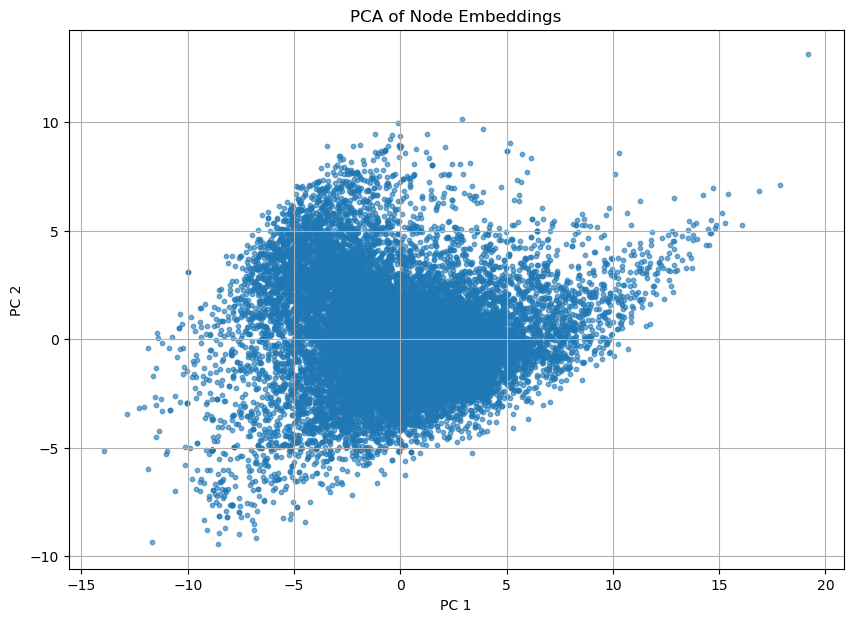

In [107]:
# Assuming embedding_dict is already loaded
embeddings = np.array(list(embedding_dict.values()))
node_ids = list(embedding_dict.keys())

# Apply PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

# Plot
plt.figure(figsize=(10, 7))
plt.scatter(reduced[:, 0], reduced[:, 1], s=10, alpha=0.6)
plt.title("PCA of Node Embeddings")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.show()


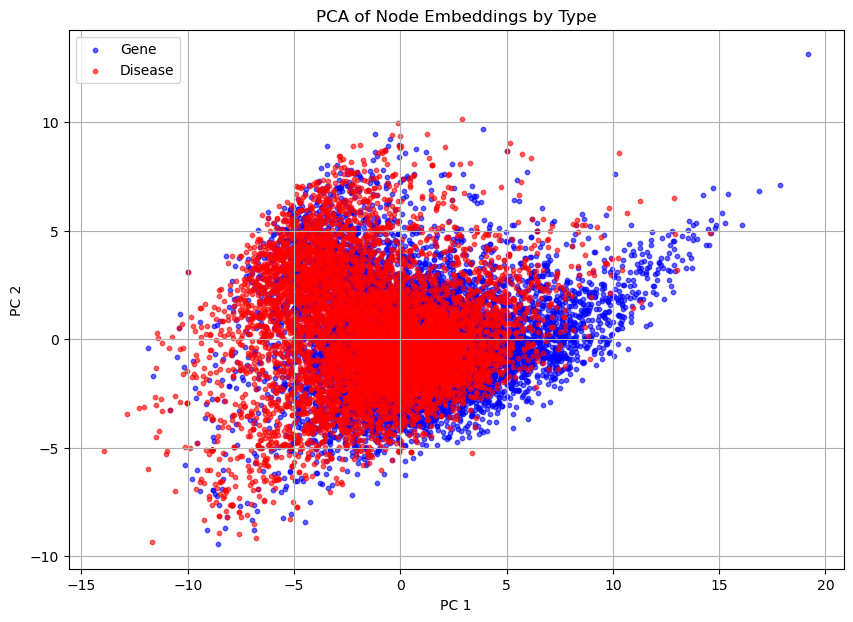

In [116]:
# Assuming embedding_dict is already loaded
embeddings = np.array(list(embedding_dict.values()))
node_ids = list(embedding_dict.keys())

# Apply PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

# Split indices by node type
gene_indices = [i for i, nid in enumerate(node_ids) if nid.startswith("G_")]
disease_indices = [i for i, nid in enumerate(node_ids) if nid.startswith("D_")]

# Plot
plt.figure(figsize=(10, 7))
plt.scatter(reduced[gene_indices, 0], reduced[gene_indices, 1], s=10, alpha=0.6, label='Gene', c='blue')
plt.scatter(reduced[disease_indices, 0], reduced[disease_indices, 1], s=10, alpha=0.6, label='Disease', c='red')
plt.title("PCA of Node Embeddings by Type")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.grid(True)
plt.show()


We can see that they are similar but still differ, which can help the model learn.

In [108]:

# Convert embedding_dict to matrix
embeddings = np.array(list(embedding_dict.values()))
node_ids = list(embedding_dict.keys())

# Apply PCA to 128 dimensions
pca = PCA(n_components=128)
embeddings_128d = pca.fit_transform(embeddings)

# Optional: create a new dict with reduced embeddings
embedding_dict_128d = {
    node_id: vec for node_id, vec in zip(node_ids, embeddings_128d)
}


In [112]:
pyg_data_pca = build_pyg_data_from_nx(train_graph, embedding_dict=embedding_dict_128d, use_random_embeddings=False,feature_dim=128)


In [113]:
def compare_all_models_pca(data, val_edges, test_edges, relation2id, epochs=100, lr=0.01):
    summary = []
    all_reports = {}

    models = {
        "GCN": GCNEncoder(in_channels=128, hidden_channels=64, out_channels=32),
        "GAT": GATEncoder(in_channels=128, hidden_channels=64, out_channels=32),
        "Transformer": GraphTransformerEncoder(in_channels=128, hidden_channels=64, out_channels=32)
    }

    for name, encoder in models.items():
        print(f"\n Training {name}...")

        classifier = EdgeClassifier(node_emb_dim=32, num_classes=3)
        encoder = encoder.to(data.x.device)
        classifier = classifier.to(data.x.device)
        optimizer = Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=lr)
        loss_fn = torch.nn.CrossEntropyLoss()

        start = time.time()

        for epoch in range(1, epochs + 1):
            encoder.train()
            classifier.train()
            optimizer.zero_grad()

            h = encoder(data.x, data.edge_index)
            out = classifier(h, data.edge_index)
            loss = loss_fn(out, data.y)
            loss.backward()
            optimizer.step()

        duration = time.time() - start

        val_acc, val_f1, val_report = evaluate_on_edges(val_edges, data, encoder, classifier, relation2id)
        test_acc, test_f1, test_report = evaluate_on_edges(test_edges, data, encoder, classifier, relation2id)

        summary.append({
            "Model": name,
            "Val Accuracy": round(val_acc, 4),
            "Val F1": round(val_f1, 4),
            "Test Accuracy": round(test_acc, 4),
            "Test F1": round(test_f1, 4),
            "Train Time (s)": round(duration, 2)
        })

        all_reports[name] = {
            "val": val_report,
            "test": test_report
        }

    df_summary = pd.DataFrame(summary)
    display(df_summary)
    return all_reports

In [115]:
compare_all_models_pca(pyg_data_pca, val_edges, test_edges, relation2id, epochs=200, lr=0.01)


 Training GCN...

 Training GAT...

 Training Transformer...


,Model,Val Accuracy,Val F1,Test Accuracy,Test F1,Train Time (s)
0,GCN,0.4909,0.4483,0.4757,0.4523,7.64
1,GAT,0.5455,0.4942,0.5054,0.4722,26.70
2,Transformer,0.5465,0.5144,0.5282,0.4927,37.57


{'GCN': {'val': {'therapeutic': {'precision': 0.4107883817427386,
    'recall': 0.28205128205128205,
    'f1-score': 0.3344594594594595,
    'support': 351.0},
   'biomarker': {'precision': 0.6489028213166145,
    'recall': 0.3544520547945205,
    'f1-score': 0.4584717607973422,
    'support': 1752.0},
   'genomic_alterations': {'precision': 0.42257897462454685,
    'recall': 0.7953216374269005,
    'f1-score': 0.5519107203246534,
    'support': 1026.0},
   'accuracy': 0.49089165867689355,
   'macro avg': {'precision': 0.4940900592279666,
    'recall': 0.4772749914242344,
    'f1-score': 0.448280646860485,
    'support': 3129.0},
   'weighted avg': {'precision': 0.547980342890123,
    'recall': 0.49089165867689355,
    'f1-score': 0.47519916722285344,
    'support': 3129.0}},
  'test': {'therapeutic': {'precision': 0.45098039215686275,
    'recall': 0.3382352941176471,
    'f1-score': 0.3865546218487395,
    'support': 340.0},
   'biomarker': {'precision': 0.6423357664233577,
    'reca

#### Lowering the embedings length with PCA does not help!

### LLM which was trained on the graph with no NA connections:

In [121]:

embedding_path = "C:/Users/adamb/Desktop/works/MSC/סמסטר ב/למידה עמוקה למתקדמים/Data/archive/node_features_no_na.npz"

# Load and inspect
embeddings_no_na = np.load(embedding_path, allow_pickle=True)
embeddings_no_na_dict = dict(embeddings_no_na)

print(f"Total nodes with embeddings: {len(embeddings_no_na_dict)}")

sample_keys = list(embeddings_no_na_dict.keys())[:5]
print("Sample node IDs:", sample_keys)

first_key = sample_keys[0]
print(f"Embedding shape for {first_key}:", embeddings_no_na_dict[first_key].shape)
print(f"First 10 values:\n{embeddings_no_na_dict[first_key][:10]}")

Total nodes with embeddings: 13591
Sample node IDs: ['G_80184', 'G_11080', 'G_338', 'G_4352', 'G_6732']
Embedding shape for G_80184: (768,)
First 10 values:
[-0.64639513  0.37741327  0.30964416 -0.23457181 -0.54880123  0.2871731
  0.48553236  0.11173171  0.00912179 -0.64558649]


In [122]:
pyg_data_no_na = build_pyg_data_from_nx(train_graph, embedding_dict=embeddings_no_na_dict, use_random_embeddings=False)


In [126]:
compare_all_models(pyg_data_no_na, val_edges, test_edges, relation2id, epochs=200, lr=0.01)


 Training GCN...

 Training GAT...

 Training Transformer...


,Model,Val Accuracy,Val F1,Test Accuracy,Test F1,Train Time (s)
0,GCN,0.4081,0.3775,0.4236,0.3958,9.15
1,GAT,0.5273,0.4860,0.5084,0.4725,30.90
2,Transformer,0.5411,0.4845,0.5444,0.5027,71.44


{'GCN': {'val': {'therapeutic': {'precision': 0.41767068273092367,
    'recall': 0.2962962962962963,
    'f1-score': 0.3466666666666667,
    'support': 351.0},
   'biomarker': {'precision': 0.5760869565217391,
    'recall': 0.1815068493150685,
    'f1-score': 0.2760416666666667,
    'support': 1752.0},
   'genomic_alterations': {'precision': 0.36726804123711343,
    'recall': 0.8333333333333334,
    'f1-score': 0.5098389982110912,
    'support': 1026.0},
   'accuracy': 0.40811760945989134,
   'macro avg': {'precision': 0.4536752268299254,
    'recall': 0.4370454929815661,
    'f1-score': 0.37751577718147483,
    'support': 3129.0},
   'weighted avg': {'precision': 0.48984460459377427,
    'recall': 0.40811760945989134,
    'f1-score': 0.36062633817979534,
    'support': 3129.0}},
  'test': {'therapeutic': {'precision': 0.44635193133047213,
    'recall': 0.3058823529411765,
    'f1-score': 0.36300174520069806,
    'support': 340.0},
   'biomarker': {'precision': 0.6711281070745698,
    

embedings from LLM without NA connection is not helping the model vs random embedings.

#### We can see that the embedings with all the inforamtion (including NAs) help the model and are better.

## Link Prediction

Until now we checked the type of the connection, now lets check if there is a connection at all (NAs vs non-NA).

As we learned from the data connection of type NA means that there was a research which checked for a connection between the gene and disease, and didn't find one.

### Functions for binary connections:

In [26]:
def extract_edges_and_texts_binary(jsonl_path, balance_ratio=1.0, balance_negatives=True):
    positive_edges = []
    negative_edges = []
    gene_texts = defaultdict(list)
    disease_texts = defaultdict(list)

    with open(jsonl_path, 'r') as f:
        for line in f:
            entry = json.loads(line.strip())
            text = entry["text"]
            gene_id = f"G_{entry['h']['id']}"
            disease_id = f"D_{entry['t']['id']}"

            gene_texts[gene_id].append(text)
            disease_texts[disease_id].append(text)

            if entry["relation"] != "NA":
                positive_edges.append({
                    "gene_id": gene_id,
                    "gene_name": entry["h"]["name"],
                    "disease_id": disease_id,
                    "disease_name": entry["t"]["name"],
                    "label": 1
                })
            else:
                negative_edges.append({
                    "gene_id": gene_id,
                    "gene_name": entry["h"]["name"],
                    "disease_id": disease_id,
                    "disease_name": entry["t"]["name"],
                    "label": 0
                })

    # Balance or keep all negatives
    if balance_negatives:
        num_negative = int(len(positive_edges) * balance_ratio)
        sampled_negatives = random.sample(negative_edges, min(len(negative_edges), num_negative))
    else:
        sampled_negatives = negative_edges

    print(f"Positive edges: {len(positive_edges)}")
    print(f"Negative edges used: {len(sampled_negatives)} (from {len(negative_edges)} total NAs)")

    all_edges = positive_edges + sampled_negatives
    random.seed(42)
    random.shuffle(all_edges)

    return all_edges, gene_texts, disease_texts


In [27]:
def build_binary_graph(edge_list):
    B = nx.Graph()
    for edge in edge_list:
        gene = edge["gene_id"]
        disease = edge["disease_id"]
        B.add_node(gene, label=edge["gene_name"], type="gene")
        B.add_node(disease, label=edge["disease_name"], type="disease")

        # Always add the edge, even if it's a negative sample
        B.add_edge(gene, disease, label=edge["label"])  # label is 0 or 1
    return B


In [28]:
def visualize_clean_subgraph(G, max_nodes=50, title="Gene–Disease Bipartite Subgraph"):
    top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:max_nodes]
    sub_nodes = [n for n, _ in top_nodes]
    subgraph = G.subgraph(sub_nodes)

    pos = nx.spring_layout(subgraph, k=0.9, iterations=100, seed=42)
    node_colors = ['skyblue' if subgraph.nodes[n]['type'] == 'gene' else 'lightcoral' for n in subgraph.nodes]
    labels = nx.get_node_attributes(subgraph, 'label')

    plt.figure(figsize=(16, 12))
    nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=1500)
    nx.draw_networkx_edges(subgraph, pos, edge_color='gray')
    nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=10, font_weight='bold')

    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


#### Creating 2 datasets: sampling so the distribution won't be skewed, and keeping the data as is.

We can see the graph without type of connection:

Positive edges: 56115
Negative edges used: 56115 (from 122149 total NAs)
Positive edges: 4987
Negative edges used: 15206 (from 15206 total NAs)
Positive edges: 4908
Negative edges used: 15608 (from 15608 total NAs)


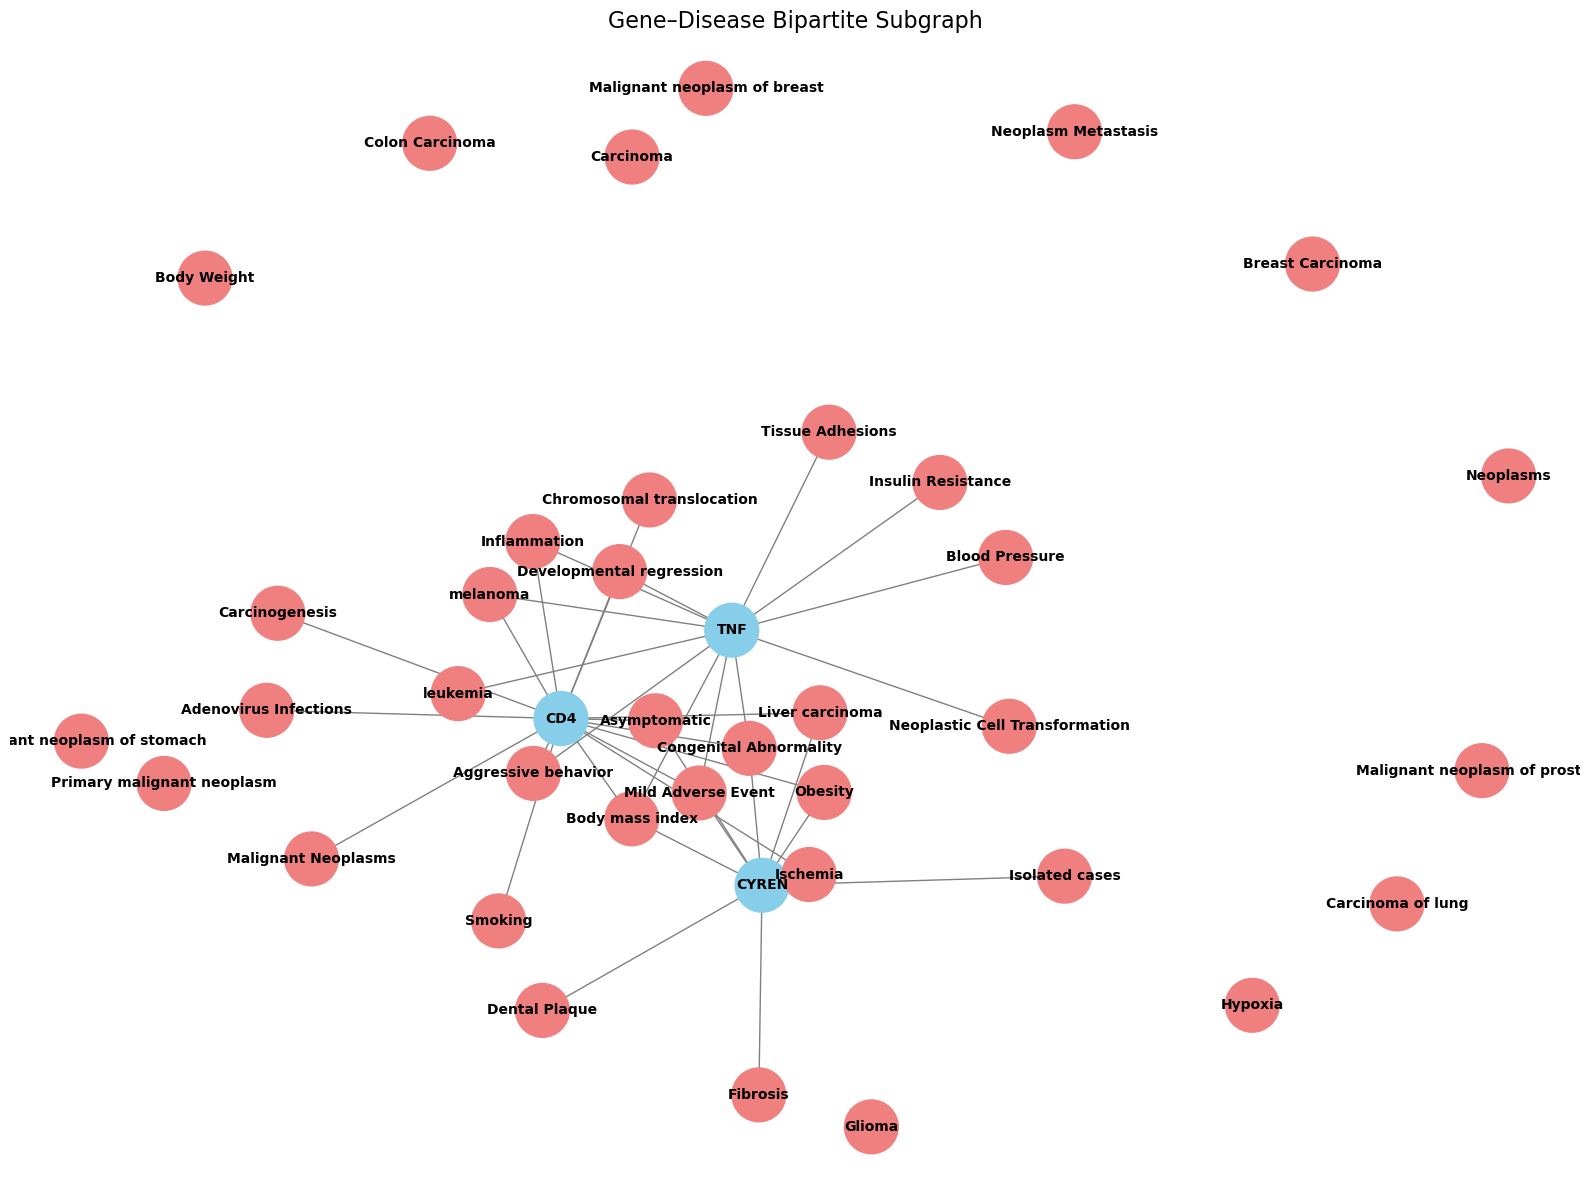

In [232]:
# === Load and parse ===
train_edges_binary, train_gene_texts, train_disease_texts = extract_edges_and_texts_binary(train_path, balance_ratio=1.0)
val_edges_binary, val_gene_texts, val_disease_texts = extract_edges_and_texts_binary(val_path, balance_negatives=False)
test_edges_binary, test_gene_texts, test_disease_texts = extract_edges_and_texts_binary(test_path, balance_negatives=False)

# === Combine all node texts (for embeddings) ===
all_gene_texts = defaultdict(list)
all_disease_texts = defaultdict(list)

for d in [train_gene_texts, val_gene_texts, test_gene_texts]:
    for k, v in d.items():
        all_gene_texts[k].extend(v)

for d in [train_disease_texts, val_disease_texts, test_disease_texts]:
    for k, v in d.items():
        all_disease_texts[k].extend(v)

# === Build training graph (only labeled=1 edges) ===
train_graph_binary = build_binary_graph(train_edges_binary)

# === Visualize small subgraph ===
visualize_clean_subgraph(train_graph_binary, max_nodes=40)


In [29]:
# === Load and parse ===
train_edges_binary_original, train_gene_texts, train_disease_texts = extract_edges_and_texts_binary(train_path, balance_negatives=False)
val_edges_binary_original, val_gene_texts, val_disease_texts = extract_edges_and_texts_binary(val_path, balance_negatives=False)
test_edges_binary_original, test_gene_texts, test_disease_texts = extract_edges_and_texts_binary(test_path, balance_negatives=False)

# === Combine all node texts (for embeddings) ===
all_gene_texts = defaultdict(list)
all_disease_texts = defaultdict(list)

for d in [train_gene_texts, val_gene_texts, test_gene_texts]:
    for k, v in d.items():
        all_gene_texts[k].extend(v)

for d in [train_disease_texts, val_disease_texts, test_disease_texts]:
    for k, v in d.items():
        all_disease_texts[k].extend(v)

# === Build training graph (only labeled=1 edges) ===
train_graph_binary_original = build_binary_graph(train_edges_binary_original)

Positive edges: 56115
Negative edges used: 122149 (from 122149 total NAs)
Positive edges: 4987
Negative edges used: 15206 (from 15206 total NAs)
Positive edges: 4908
Negative edges used: 15608 (from 15608 total NAs)


In [30]:
def build_pyg_data_from_nx_binary(graph: nx.Graph, embedding_dict=None, use_random_embeddings=False, feature_dim=768):
    # === Step 1: Map node string IDs to integer indices ===
    node_to_idx = {node: i for i, node in enumerate(graph.nodes())}
    idx_to_node = {i: node for node, i in node_to_idx.items()}

    # === Step 2: Create edge_index and binary edge labels ===
    edge_index = []
    edge_labels = []

    for u, v, data in graph.edges(data=True):
        src = node_to_idx[u]
        dst = node_to_idx[v]
        label = data.get("label", 1)  # fallback to 1 if label not present

        # Add both directions since the graph is undirected
        edge_index.append([src, dst])
        edge_index.append([dst, src])
        edge_labels.append(label)
        edge_labels.append(label)

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    y = torch.tensor(edge_labels, dtype=torch.long)

    # === Step 3: Create node features matrix ===
    x = torch.zeros((len(graph.nodes()), feature_dim), dtype=torch.float)

    for node, idx in node_to_idx.items():
        if not use_random_embeddings and embedding_dict is not None and node in embedding_dict:
            x[idx] = torch.tensor(embedding_dict[node], dtype=torch.float)
        else:
            x[idx] = torch.randn(feature_dim)

    # === Step 4: Return PyG data object ===
    data = Data(x=x, edge_index=edge_index, y=y)
    data.node_to_idx = node_to_idx
    data.idx_to_node = idx_to_node
    return data


creating the training data:

In [235]:
pyg_data_binary = build_pyg_data_from_nx_binary(train_graph_binary, embedding_dict=embedding_dict, use_random_embeddings=False)
pyg_data_binary_original = build_pyg_data_from_nx_binary(train_graph_binary_original, embedding_dict=embedding_dict, use_random_embeddings=False)


In [31]:
def train_model_binary(data, encoder, classifier, epochs=50, lr=0.01):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data = data.to(device)
    encoder = encoder.to(device)
    classifier = classifier.to(device)

    optimizer = Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=lr)
    loss_fn = BCEWithLogitsLoss()

    for epoch in range(1, epochs + 1):
        encoder.train()
        classifier.train()

        optimizer.zero_grad()
        h = encoder(data.x, data.edge_index)
        logits = classifier(h, data.edge_index)

        loss = loss_fn(logits, data.y.unsqueeze(1).float())
        loss.backward()
        optimizer.step()

        # Optional: evaluation on training set
        encoder.eval()
        classifier.eval()
        with torch.no_grad():
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs > 0.5).astype(int).flatten()
            labels = data.y.cpu().numpy().flatten()
            acc = accuracy_score(labels, preds)
            f1 = f1_score(labels, preds)

        print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | Accuracy: {acc:.4f} | F1: {f1:.4f}")


In [32]:
def evaluate_model_binary(edge_list, data, encoder, classifier, name="Validation"):
    encoder.eval()
    classifier.eval()
    device = data.x.device

    y_true = []
    y_pred = []

    with torch.no_grad():
        h = encoder(data.x, data.edge_index)

        for edge in edge_list:
            gene = edge["gene_id"]
            disease = edge["disease_id"]

            if gene not in data.node_to_idx or disease not in data.node_to_idx:
                continue  # skip if node not in graph

            u = data.node_to_idx[gene]
            v = data.node_to_idx[disease]

            logits = classifier(h, torch.tensor([[u], [v]], dtype=torch.long, device=device))
            prob = torch.sigmoid(logits).item()
            pred = int(prob > 0.5)
            label = edge["label"]  # 0 or 1

            y_true.append(label)
            y_pred.append(pred)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n{name} Results:")
    print(f"Accuracy: {acc:.4f} | F1: {f1:.4f}")
    print(classification_report(y_true, y_pred, target_names=["No Link", "Link"]))


In [33]:
def evaluate_on_edges_binary(edge_list, data, encoder, classifier, threshold=0.5):
    encoder.eval()
    classifier.eval()
    device = data.x.device

    y_true = []
    y_pred = []

    with torch.no_grad():
        h = encoder(data.x, data.edge_index)

        for edge in edge_list:
            gene = edge["gene_id"]
            disease = edge["disease_id"]

            if gene not in data.node_to_idx or disease not in data.node_to_idx:
                continue  # Skip if node is not in the graph

            u = data.node_to_idx[gene]
            v = data.node_to_idx[disease]

            logits = classifier(h, torch.tensor([[u], [v]], dtype=torch.long, device=device))
            prob = torch.sigmoid(logits).item()
            pred = 1 if prob >= threshold else 0

            y_true.append(edge["label"])
            y_pred.append(pred)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred) 
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

    return acc, f1, report


In [34]:
def compare_all_models_binary(data, val_edges, test_edges, epochs=100, lr=0.01):
    summary = []
    all_reports = {}

    models = {
        "GCN": GCNEncoder(in_channels=768, hidden_channels=64, out_channels=32),
        "GAT": GATEncoder(in_channels=768, hidden_channels=64, out_channels=32),
        "Transformer": GraphTransformerEncoder(in_channels=768, hidden_channels=64, out_channels=32)
    }

    for name, encoder in models.items():
        print(f"\nTraining {name}...")

        classifier = EdgeClassifier(node_emb_dim=32, num_classes=1)  # Binary output
        encoder = encoder.to(data.x.device)
        classifier = classifier.to(data.x.device)
        optimizer = Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=lr)
        loss_fn = torch.nn.BCEWithLogitsLoss()

        start = time.time()

        for epoch in range(1, epochs + 1):
            encoder.train()
            classifier.train()
            optimizer.zero_grad()

            h = encoder(data.x, data.edge_index)
            logits = classifier(h, data.edge_index)
            labels = data.y.float().unsqueeze(1)  # shape [E, 1]
            loss = loss_fn(logits, labels)

            loss.backward()
            optimizer.step()

        duration = time.time() - start

        # Evaluation
        val_acc, val_f1, val_report = evaluate_on_edges_binary(val_edges, data, encoder, classifier)

        val_precision = val_report["1"]["precision"]

        summary.append({
            "Model": name,
            "Val Accuracy": round(val_acc, 4),
            "Val Precision": round(val_precision, 4),

        })

        all_reports[name] = {
            "val": val_report,
        }

    df_summary = pd.DataFrame(summary)
    display(df_summary)
    return all_reports


### The models

Lets start with GCN as an example:

In [267]:
encoder = GCNEncoder(in_channels=768, hidden_channels=64, out_channels=32)
classifier = EdgeClassifier(node_emb_dim=32, num_classes=1)


Sampled dataset:

In [268]:
train_model_binary(pyg_data_binary, encoder, classifier, epochs=100, lr=0.01)


Epoch 001 | Loss: 0.7604 | Accuracy: 0.5063 | F1: 0.4801
Epoch 002 | Loss: 2.2612 | Accuracy: 0.5246 | F1: 0.0148
Epoch 003 | Loss: 1.4315 | Accuracy: 0.5094 | F1: 0.5508
Epoch 004 | Loss: 0.9693 | Accuracy: 0.5129 | F1: 0.6242
Epoch 005 | Loss: 0.6907 | Accuracy: 0.5300 | F1: 0.5610
Epoch 006 | Loss: 0.6669 | Accuracy: 0.5299 | F1: 0.0015
Epoch 007 | Loss: 0.6729 | Accuracy: 0.5296 | F1: 0.0002
Epoch 008 | Loss: 0.6728 | Accuracy: 0.5296 | F1: 0.0001
Epoch 009 | Loss: 0.6701 | Accuracy: 0.5296 | F1: 0.0002
Epoch 010 | Loss: 0.6683 | Accuracy: 0.5302 | F1: 0.0030
Epoch 011 | Loss: 0.6681 | Accuracy: 0.5344 | F1: 0.0254
Epoch 012 | Loss: 0.6687 | Accuracy: 0.5463 | F1: 0.0987
Epoch 013 | Loss: 0.6687 | Accuracy: 0.5588 | F1: 0.1753
Epoch 014 | Loss: 0.6676 | Accuracy: 0.5607 | F1: 0.1837
Epoch 015 | Loss: 0.6654 | Accuracy: 0.5531 | F1: 0.1351
Epoch 016 | Loss: 0.6630 | Accuracy: 0.5433 | F1: 0.0752
Epoch 017 | Loss: 0.6613 | Accuracy: 0.5377 | F1: 0.0423
Epoch 018 | Loss: 0.6605 | Accu

In [269]:
evaluate_model_binary(val_edges_binary, pyg_data_binary, encoder, classifier, name="Validation")



Validation Results:
Accuracy: 0.7677 | F1: 0.5109
              precision    recall  f1-score   support

     No Link       0.89      0.81      0.85     14621
        Link       0.44      0.61      0.51      3601

    accuracy                           0.77     18222
   macro avg       0.67      0.71      0.68     18222
weighted avg       0.80      0.77      0.78     18222



In [270]:
encoder = GCNEncoder(in_channels=768, hidden_channels=64, out_channels=32)
classifier = EdgeClassifier(node_emb_dim=32, num_classes=1)


Original dataset:

In [271]:
train_model_binary(pyg_data_binary_original, encoder, classifier, epochs=100, lr=0.01)


Epoch 001 | Loss: 0.6834 | Accuracy: 0.5691 | F1: 0.2546
Epoch 002 | Loss: 2.8871 | Accuracy: 0.6667 | F1: 0.0000
Epoch 003 | Loss: 2.9224 | Accuracy: 0.5036 | F1: 0.3911
Epoch 004 | Loss: 1.6126 | Accuracy: 0.5179 | F1: 0.3660
Epoch 005 | Loss: 0.7938 | Accuracy: 0.6527 | F1: 0.0659
Epoch 006 | Loss: 0.7296 | Accuracy: 0.6667 | F1: 0.0001
Epoch 007 | Loss: 0.6129 | Accuracy: 0.6667 | F1: 0.0004
Epoch 008 | Loss: 0.5914 | Accuracy: 0.6731 | F1: 0.0414
Epoch 009 | Loss: 0.6555 | Accuracy: 0.6227 | F1: 0.4401
Epoch 010 | Loss: 0.6218 | Accuracy: 0.6756 | F1: 0.2257
Epoch 011 | Loss: 0.5992 | Accuracy: 0.6716 | F1: 0.0329
Epoch 012 | Loss: 0.5927 | Accuracy: 0.6672 | F1: 0.0033
Epoch 013 | Loss: 0.5942 | Accuracy: 0.6668 | F1: 0.0007
Epoch 014 | Loss: 0.5970 | Accuracy: 0.6667 | F1: 0.0004
Epoch 015 | Loss: 0.5964 | Accuracy: 0.6667 | F1: 0.0003
Epoch 016 | Loss: 0.5919 | Accuracy: 0.6667 | F1: 0.0002
Epoch 017 | Loss: 0.5868 | Accuracy: 0.6667 | F1: 0.0004
Epoch 018 | Loss: 0.5842 | Accu

In [272]:
evaluate_model_binary(val_edges_binary_original, pyg_data_binary_original, encoder, classifier, name="Validation")



Validation Results:
Accuracy: 0.8257 | F1: 0.4626
              precision    recall  f1-score   support

     No Link       0.85      0.94      0.90     14832
        Link       0.62      0.37      0.46      3764

    accuracy                           0.83     18596
   macro avg       0.74      0.66      0.68     18596
weighted avg       0.81      0.83      0.81     18596



### Now lets see all the models:

We want high precision so that the model would have small amount of false-positives (which we will explore later), so we will choose a higher threshold later on.

With sampling for not skewed dataset:

In [275]:
compare_all_models_binary(pyg_data_binary, val_edges_binary, test_edges_binary, epochs=100, lr=0.01)


Training GCN...

Training GAT...

Training Transformer...


,Model,Val Accuracy,Val Precision
0,GCN,0.7659,0.4348
1,GAT,0.7860,0.4735
2,Transformer,0.8020,0.4993


{'GCN': {'val': {'0': {'precision': 0.8945363102949021,
    'recall': 0.802886259489775,
    'f1-score': 0.8462370242214533,
    'support': 14621.0},
   '1': {'precision': 0.434791135516768,
    'recall': 0.6156623160233269,
    'f1-score': 0.5096551724137931,
    'support': 3601.0},
   'accuracy': 0.7658873888705959,
   'macro avg': {'precision': 0.6646637229058351,
    'recall': 0.709274287756551,
    'f1-score': 0.6779460983176232,
    'support': 18222.0},
   'weighted avg': {'precision': 0.803682267139592,
    'recall': 0.7658873888705959,
    'f1-score': 0.7797223030953757,
    'support': 18222.0}}},
 'GAT': {'val': {'0': {'precision': 0.9258082452935102,
    'recall': 0.7971410984200807,
    'f1-score': 0.856670341786108,
    'support': 14621.0},
   '1': {'precision': 0.4734599680454465,
    'recall': 0.7406276034434879,
    'f1-score': 0.5776478232618584,
    'support': 3601.0},
   'accuracy': 0.7859729996707276,
   'macro avg': {'precision': 0.6996341066694783,
    'recall': 0.

The original dataset:

In [276]:
compare_all_models_binary(pyg_data_binary_original, val_edges_binary_original, test_edges_binary_original, epochs=100, lr=0.01)


Training GCN...

Training GAT...

Training Transformer...


,Model,Val Accuracy,Val Precision
0,GCN,0.8088,0.5748
1,GAT,0.8090,0.5507
2,Transformer,0.8343,0.7293


{'GCN': {'val': {'0': {'precision': 0.8278388278388278,
    'recall': 0.9599514563106796,
    'f1-score': 0.8890137679123349,
    'support': 14832.0},
   '1': {'precision': 0.5748031496062992,
    'recall': 0.21333687566418705,
    'f1-score': 0.311180003875218,
    'support': 3764.0},
   'accuracy': 0.8088298558829856,
   'macro avg': {'precision': 0.7013209887225635,
    'recall': 0.5866441659874333,
    'f1-score': 0.6000968858937764,
    'support': 18596.0},
   'weighted avg': {'precision': 0.7766220988182192,
    'recall': 0.8088298558829856,
    'f1-score': 0.7720549440880873,
    'support': 18596.0}}},
 'GAT': {'val': {'0': {'precision': 0.8416939294801891,
    'recall': 0.9366909385113269,
    'f1-score': 0.8866551790158913,
    'support': 14832.0},
   '1': {'precision': 0.5507177033492823,
    'recall': 0.3057917109458023,
    'f1-score': 0.39323539460198154,
    'support': 3764.0},
   'accuracy': 0.8089911808991181,
   'macro avg': {'precision': 0.6962058164147357,
    'recal

### Transformers are the best, learning on the entire graph

Now lets train the transformer binary model again with 200 epochs:

In [280]:
encoder = GraphTransformerEncoder(in_channels=768, hidden_channels=64, out_channels=32)
classifier = EdgeClassifier(node_emb_dim=32, num_classes=1)


In [281]:
train_model_binary(pyg_data_binary_original, encoder, classifier, epochs=200, lr=0.01)


Epoch 001 | Loss: 0.7283 | Accuracy: 0.3333 | F1: 0.4999
Epoch 002 | Loss: 12.1568 | Accuracy: 0.6667 | F1: 0.0000
Epoch 003 | Loss: 0.9068 | Accuracy: 0.3335 | F1: 0.4998
Epoch 004 | Loss: 0.6042 | Accuracy: 0.7055 | F1: 0.3672
Epoch 005 | Loss: 0.8428 | Accuracy: 0.6668 | F1: 0.0008
Epoch 006 | Loss: 0.6268 | Accuracy: 0.6681 | F1: 0.0090
Epoch 007 | Loss: 0.6299 | Accuracy: 0.7061 | F1: 0.3875
Epoch 008 | Loss: 0.6566 | Accuracy: 0.6826 | F1: 0.5229
Epoch 009 | Loss: 0.6314 | Accuracy: 0.6938 | F1: 0.2128
Epoch 010 | Loss: 0.6146 | Accuracy: 0.6682 | F1: 0.0098
Epoch 011 | Loss: 0.6142 | Accuracy: 0.6667 | F1: 0.0000
Epoch 012 | Loss: 0.6194 | Accuracy: 0.6667 | F1: 0.0000
Epoch 013 | Loss: 0.6218 | Accuracy: 0.6667 | F1: 0.0000
Epoch 014 | Loss: 0.6192 | Accuracy: 0.6667 | F1: 0.0000
Epoch 015 | Loss: 0.6137 | Accuracy: 0.6667 | F1: 0.0000
Epoch 016 | Loss: 0.6087 | Accuracy: 0.6667 | F1: 0.0000
Epoch 017 | Loss: 0.6054 | Accuracy: 0.6667 | F1: 0.0000
Epoch 018 | Loss: 0.6033 | Acc

Epoch 145 | Loss: 0.3863 | Accuracy: 0.8166 | F1: 0.6850
Epoch 146 | Loss: 0.4010 | Accuracy: 0.8083 | F1: 0.7349
Epoch 147 | Loss: 0.3795 | Accuracy: 0.8228 | F1: 0.7167
Epoch 148 | Loss: 0.3951 | Accuracy: 0.8108 | F1: 0.6564
Epoch 149 | Loss: 0.3836 | Accuracy: 0.8202 | F1: 0.7286
Epoch 150 | Loss: 0.3897 | Accuracy: 0.8159 | F1: 0.7305
Epoch 151 | Loss: 0.3967 | Accuracy: 0.8110 | F1: 0.6615
Epoch 152 | Loss: 0.3804 | Accuracy: 0.8195 | F1: 0.7100
Epoch 153 | Loss: 0.3936 | Accuracy: 0.8128 | F1: 0.7333
Epoch 154 | Loss: 0.3856 | Accuracy: 0.8163 | F1: 0.6801
Epoch 155 | Loss: 0.3792 | Accuracy: 0.8192 | F1: 0.6940
Epoch 156 | Loss: 0.3878 | Accuracy: 0.8162 | F1: 0.7370
Epoch 157 | Loss: 0.3756 | Accuracy: 0.8220 | F1: 0.7057
Epoch 158 | Loss: 0.3814 | Accuracy: 0.8180 | F1: 0.6820
Epoch 159 | Loss: 0.3794 | Accuracy: 0.8229 | F1: 0.7368
Epoch 160 | Loss: 0.3733 | Accuracy: 0.8251 | F1: 0.7254
Epoch 161 | Loss: 0.3787 | Accuracy: 0.8190 | F1: 0.6846
Epoch 162 | Loss: 0.3724 | Accu

In [282]:
evaluate_model_binary(val_edges_binary_original, pyg_data_binary_original, encoder, classifier, name="Validation")



Validation Results:
Accuracy: 0.8593 | F1: 0.6137
              precision    recall  f1-score   support

     No Link       0.89      0.94      0.91     14832
        Link       0.69      0.55      0.61      3764

    accuracy                           0.86     18596
   macro avg       0.79      0.74      0.76     18596
weighted avg       0.85      0.86      0.85     18596



We increased the epochs to 200 explainig the slight increase in results.

### Threshold selection

We want to take only few connections which we are almost sure that they are ture, predict thier type and look at the few rows where the model is wrong (false positives).

By precision

In [280]:
encoder = GraphTransformerEncoder(in_channels=768, hidden_channels=64, out_channels=32)
classifier = EdgeClassifier(node_emb_dim=32, num_classes=1)


In [281]:
train_model_binary(pyg_data_binary_original, encoder, classifier, epochs=200, lr=0.01)


Epoch 001 | Loss: 0.7283 | Accuracy: 0.3333 | F1: 0.4999
Epoch 002 | Loss: 12.1568 | Accuracy: 0.6667 | F1: 0.0000
Epoch 003 | Loss: 0.9068 | Accuracy: 0.3335 | F1: 0.4998
Epoch 004 | Loss: 0.6042 | Accuracy: 0.7055 | F1: 0.3672
Epoch 005 | Loss: 0.8428 | Accuracy: 0.6668 | F1: 0.0008
Epoch 006 | Loss: 0.6268 | Accuracy: 0.6681 | F1: 0.0090
Epoch 007 | Loss: 0.6299 | Accuracy: 0.7061 | F1: 0.3875
Epoch 008 | Loss: 0.6566 | Accuracy: 0.6826 | F1: 0.5229
Epoch 009 | Loss: 0.6314 | Accuracy: 0.6938 | F1: 0.2128
Epoch 010 | Loss: 0.6146 | Accuracy: 0.6682 | F1: 0.0098
Epoch 011 | Loss: 0.6142 | Accuracy: 0.6667 | F1: 0.0000
Epoch 012 | Loss: 0.6194 | Accuracy: 0.6667 | F1: 0.0000
Epoch 013 | Loss: 0.6218 | Accuracy: 0.6667 | F1: 0.0000
Epoch 014 | Loss: 0.6192 | Accuracy: 0.6667 | F1: 0.0000
Epoch 015 | Loss: 0.6137 | Accuracy: 0.6667 | F1: 0.0000
Epoch 016 | Loss: 0.6087 | Accuracy: 0.6667 | F1: 0.0000
Epoch 017 | Loss: 0.6054 | Accuracy: 0.6667 | F1: 0.0000
Epoch 018 | Loss: 0.6033 | Acc

Epoch 145 | Loss: 0.3863 | Accuracy: 0.8166 | F1: 0.6850
Epoch 146 | Loss: 0.4010 | Accuracy: 0.8083 | F1: 0.7349
Epoch 147 | Loss: 0.3795 | Accuracy: 0.8228 | F1: 0.7167
Epoch 148 | Loss: 0.3951 | Accuracy: 0.8108 | F1: 0.6564
Epoch 149 | Loss: 0.3836 | Accuracy: 0.8202 | F1: 0.7286
Epoch 150 | Loss: 0.3897 | Accuracy: 0.8159 | F1: 0.7305
Epoch 151 | Loss: 0.3967 | Accuracy: 0.8110 | F1: 0.6615
Epoch 152 | Loss: 0.3804 | Accuracy: 0.8195 | F1: 0.7100
Epoch 153 | Loss: 0.3936 | Accuracy: 0.8128 | F1: 0.7333
Epoch 154 | Loss: 0.3856 | Accuracy: 0.8163 | F1: 0.6801
Epoch 155 | Loss: 0.3792 | Accuracy: 0.8192 | F1: 0.6940
Epoch 156 | Loss: 0.3878 | Accuracy: 0.8162 | F1: 0.7370
Epoch 157 | Loss: 0.3756 | Accuracy: 0.8220 | F1: 0.7057
Epoch 158 | Loss: 0.3814 | Accuracy: 0.8180 | F1: 0.6820
Epoch 159 | Loss: 0.3794 | Accuracy: 0.8229 | F1: 0.7368
Epoch 160 | Loss: 0.3733 | Accuracy: 0.8251 | F1: 0.7254
Epoch 161 | Loss: 0.3787 | Accuracy: 0.8190 | F1: 0.6846
Epoch 162 | Loss: 0.3724 | Accu

In [60]:
def evaluate_thresholds(data, edge_list, encoder, classifier, thresholds):
    encoder.eval()
    classifier.eval()
    device = data.x.device

    accs = []
    precisions = []
    num_preds = []

    with torch.no_grad():
        h = encoder(data.x, data.edge_index)

        for threshold in thresholds:
            y_true = []
            y_pred = []

            for edge in edge_list:
                gene = edge["gene_id"]
                disease = edge["disease_id"]
                if gene not in data.node_to_idx or disease not in data.node_to_idx:
                    continue
                u = data.node_to_idx[gene]
                v = data.node_to_idx[disease]
                logits = classifier(h, torch.tensor([[u], [v]], dtype=torch.long, device=device))
                prob = torch.sigmoid(logits).item()
                pred = int(prob >= threshold)

                y_true.append(edge["label"])
                y_pred.append(pred)

            accs.append(accuracy_score(y_true, y_pred))
            precisions.append(precision_score(y_true, y_pred, zero_division=0))
            num_preds.append(sum(y_pred))

    return accs, precisions, num_preds


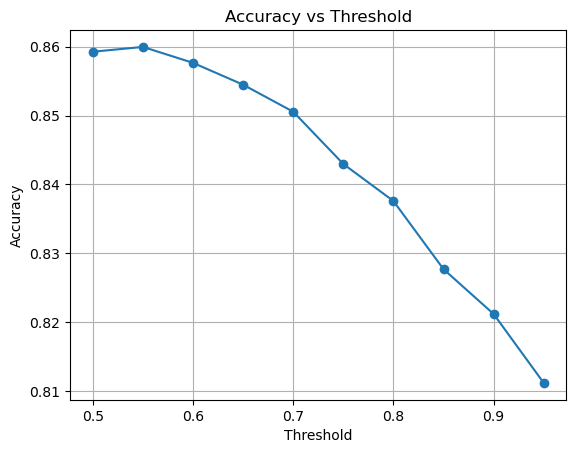

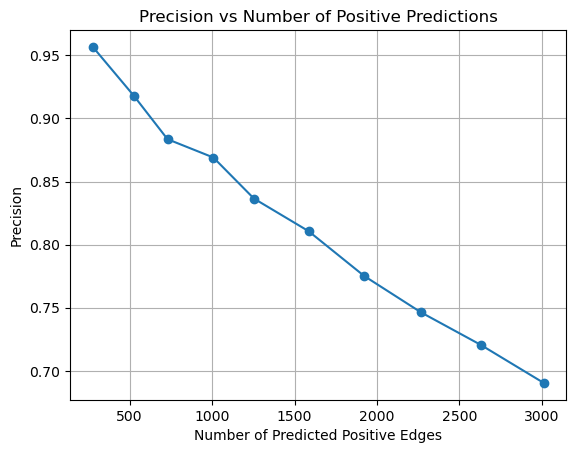

In [286]:
# === Run Evaluation ===
thresholds = [i / 100 for i in range(50, 96, 5)]
accs, precisions, num_preds = evaluate_thresholds(
    data=pyg_data_binary_original,
    edge_list=val_edges_binary_original,
    encoder=encoder,
    classifier=classifier,
    thresholds=thresholds
)

# === Plot Accuracy vs Threshold ===
plt.figure()
plt.plot(thresholds, accs, marker='o')
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Threshold")
plt.grid(True)
plt.show()

# === Plot Precision vs Number of Predicted Positives ===
plt.figure()
plt.plot(num_preds, precisions, marker='o')
plt.xlabel("Number of Predicted Positive Edges")
plt.ylabel("Precision")
plt.title("Precision vs Number of Positive Predictions")
plt.grid(True)
plt.show()


#### 86% accuracy on the validation set.

Let's try looking even at higher thresholds:

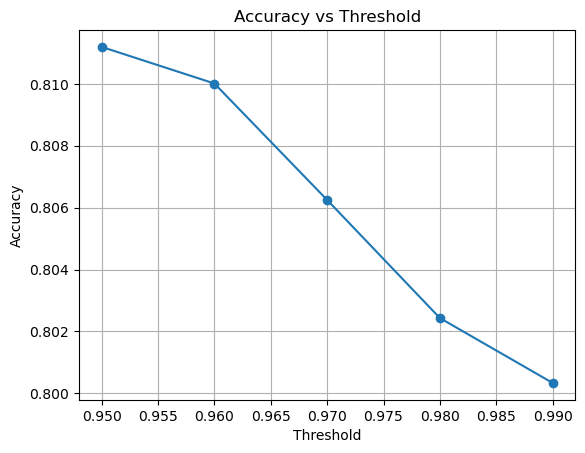

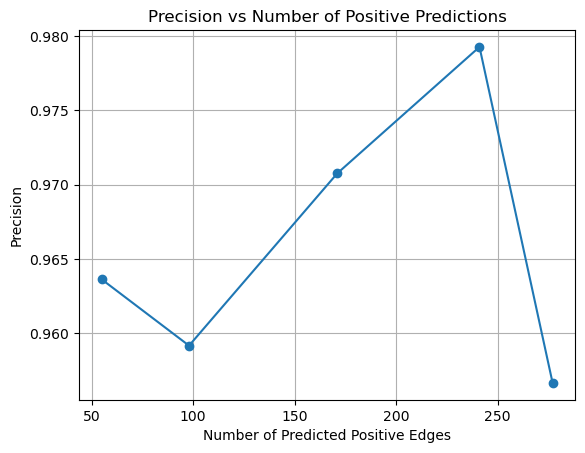

In [287]:
# === Run Evaluation ===
thresholds = [i / 100 for i in range(95, 100, 1)]
accs, precisions, num_preds = evaluate_thresholds(
    data=pyg_data_binary_original,
    edge_list=val_edges_binary_original,
    encoder=encoder,
    classifier=classifier,
    thresholds=thresholds
)

# === Plot Accuracy vs Threshold ===
plt.figure()
plt.plot(thresholds, accs, marker='o')
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Threshold")
plt.grid(True)
plt.show()

# === Plot Precision vs Number of Predicted Positives ===
plt.figure()
plt.plot(num_preds, precisions, marker='o')
plt.xlabel("Number of Predicted Positive Edges")
plt.ylabel("Precision")
plt.title("Precision vs Number of Positive Predictions")
plt.grid(True)
plt.show()


### The threshold of 96 has the highest precision - almost 98% on ~240 rows.

We will predict now the type of connection, and look at the false positives from before, the "fake conections", maybe that connection is new to the world? (or at least the dataset).

### Taking only the predicted connections to predict type of connection

as seen before, transformers with the llm embedings are the best:

## Training the best models on train+val, and predicting on test

We start by finiding the edges which the model thinks are true:

In [37]:
# === Combine train + val edges for training ===
trainval_edges = train_edges_binary_original + val_edges_binary_original

# === Combine gene texts ===
all_gene_texts = defaultdict(list)
for d in [train_gene_texts, val_gene_texts, test_gene_texts]:
    for k, v in d.items():
        all_gene_texts[k].extend(v)

# === Combine disease texts ===
all_disease_texts = defaultdict(list)
for d in [train_disease_texts, val_disease_texts, test_disease_texts]:
    for k, v in d.items():
        all_disease_texts[k].extend(v)

# === Build training graph with only label=1 edges ===
trainval_graph = build_binary_graph(trainval_edges)

# === Build PyG data from training graph (label=1 only) ===
pyg_data_trainval = build_pyg_data_from_nx_binary(trainval_graph, embedding_dict=embedding_dict, use_random_embeddings=False)



In [40]:
# === Train on trainval and test on test ===
encoder = GraphTransformerEncoder(in_channels=768, hidden_channels=64, out_channels=32)
classifier = EdgeClassifier(node_emb_dim=32, num_classes=1)

train_model_binary(pyg_data_trainval, encoder, classifier, epochs=200, lr=0.01)

evaluate_model_binary(test_edges_binary_original, pyg_data_trainval, encoder, classifier, name="Test")


Epoch 001 | Loss: 0.6500 | Accuracy: 0.6668 | F1: 0.0012
Epoch 002 | Loss: 9.0793 | Accuracy: 0.6669 | F1: 0.0012
Epoch 003 | Loss: 12.0510 | Accuracy: 0.3333 | F1: 0.5000
Epoch 004 | Loss: 3.3632 | Accuracy: 0.3379 | F1: 0.5017
Epoch 005 | Loss: 0.9448 | Accuracy: 0.6686 | F1: 0.0122
Epoch 006 | Loss: 1.4231 | Accuracy: 0.6669 | F1: 0.0014
Epoch 007 | Loss: 1.1430 | Accuracy: 0.6669 | F1: 0.0014
Epoch 008 | Loss: 0.7578 | Accuracy: 0.6671 | F1: 0.0024
Epoch 009 | Loss: 0.6256 | Accuracy: 0.6680 | F1: 0.0372
Epoch 010 | Loss: 0.7149 | Accuracy: 0.4258 | F1: 0.5000
Epoch 011 | Loss: 0.7963 | Accuracy: 0.3512 | F1: 0.5042
Epoch 012 | Loss: 0.7820 | Accuracy: 0.3651 | F1: 0.5069
Epoch 013 | Loss: 0.7081 | Accuracy: 0.4453 | F1: 0.4749
Epoch 014 | Loss: 0.6382 | Accuracy: 0.6560 | F1: 0.0229
Epoch 015 | Loss: 0.6185 | Accuracy: 0.6675 | F1: 0.0060
Epoch 016 | Loss: 0.6395 | Accuracy: 0.6672 | F1: 0.0037
Epoch 017 | Loss: 0.6391 | Accuracy: 0.6679 | F1: 0.0102
Epoch 018 | Loss: 0.6152 | Acc

Epoch 145 | Loss: 0.3316 | Accuracy: 0.8463 | F1: 0.7550
Epoch 146 | Loss: 0.3328 | Accuracy: 0.8464 | F1: 0.7583
Epoch 147 | Loss: 0.3318 | Accuracy: 0.8458 | F1: 0.7663
Epoch 148 | Loss: 0.3337 | Accuracy: 0.8454 | F1: 0.7436
Epoch 149 | Loss: 0.3371 | Accuracy: 0.8422 | F1: 0.7722
Epoch 150 | Loss: 0.3414 | Accuracy: 0.8413 | F1: 0.7286
Epoch 151 | Loss: 0.3355 | Accuracy: 0.8431 | F1: 0.7724
Epoch 152 | Loss: 0.3303 | Accuracy: 0.8470 | F1: 0.7491
Epoch 153 | Loss: 0.3265 | Accuracy: 0.8492 | F1: 0.7660
Epoch 154 | Loss: 0.3267 | Accuracy: 0.8486 | F1: 0.7706
Epoch 155 | Loss: 0.3300 | Accuracy: 0.8480 | F1: 0.7491
Epoch 156 | Loss: 0.3333 | Accuracy: 0.8438 | F1: 0.7745
Epoch 157 | Loss: 0.3402 | Accuracy: 0.8425 | F1: 0.7268
Epoch 158 | Loss: 0.3418 | Accuracy: 0.8367 | F1: 0.7721
Epoch 159 | Loss: 0.3360 | Accuracy: 0.8443 | F1: 0.7347
Epoch 160 | Loss: 0.3254 | Accuracy: 0.8494 | F1: 0.7670
Epoch 161 | Loss: 0.3310 | Accuracy: 0.8454 | F1: 0.7752
Epoch 162 | Loss: 0.3382 | Accu

In [46]:

def plot_roc_and_compute_auc(edge_list, data, encoder, classifier):
    encoder.eval()
    classifier.eval()
    device = data.x.device

    y_true = []
    y_scores = []

    with torch.no_grad():
        h = encoder(data.x, data.edge_index)

        for edge in edge_list:
            gene = edge["gene_id"]
            disease = edge["disease_id"]
            label = edge["label"]

            if gene not in data.node_to_idx or disease not in data.node_to_idx:
                continue

            u = data.node_to_idx[gene]
            v = data.node_to_idx[disease]

            logits = classifier(h, torch.tensor([[u], [v]], dtype=torch.long, device=device))
            prob = torch.sigmoid(logits).item()

            y_true.append(label)
            y_scores.append(prob)

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return roc_auc




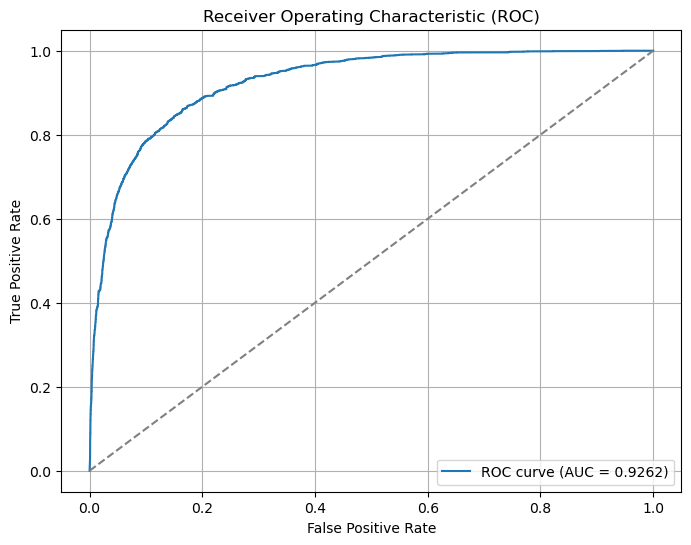

AUC: 0.9262


In [47]:
auc_value = plot_roc_and_compute_auc(test_edges_binary_original, pyg_data_trainval, encoder, classifier)
print(f"AUC: {auc_value:.4f}")

The HOGCN from the paper achived between 0.9-0.94 AUC on their datasets, meaning we did a good work (similar results to them, but the datasets are different).

## Training to find the type of connection:

We will train on the train dataset like before but test on the false positives of the binary model.

### Evaluating on the false positives:

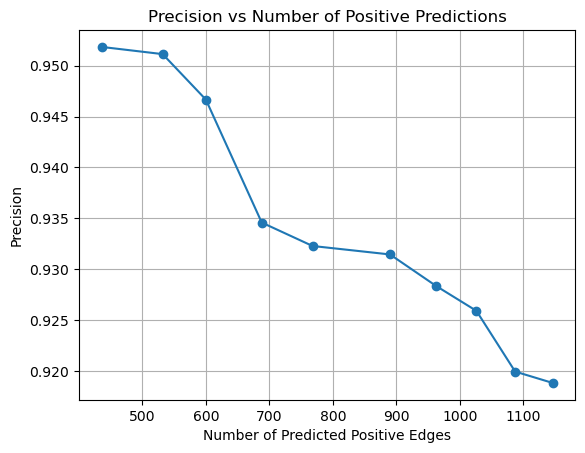

In [63]:
# === Run Evaluation ===
thresholds = [i / 100 for i in range(90, 100, 1)]
accs, precisions, num_preds = evaluate_thresholds(
    data=pyg_data_trainval,
    edge_list=test_edges_binary_original,
    encoder=encoder,
    classifier=classifier,
    thresholds=thresholds
)


# === Plot Precision vs Number of Predicted Positives ===
plt.figure()
plt.plot(num_preds, precisions, marker='o')
plt.xlabel("Number of Predicted Positive Edges")
plt.ylabel("Precision")
plt.title("Precision vs Number of Positive Predictions")
plt.grid(True)
plt.show()


In [64]:
def get_high_confidence_positive_predictions_with_fp(edge_list, data, encoder, classifier, threshold=0.96):
    encoder.eval()
    classifier.eval()
    device = data.x.device

    y_true = []
    y_pred = []
    high_conf_rows = []
    false_positives = []

    with torch.no_grad():
        h = encoder(data.x, data.edge_index)

        for edge in edge_list:
            gene = edge["gene_id"]
            disease = edge["disease_id"]
            label = edge["label"]

            if gene not in data.node_to_idx or disease not in data.node_to_idx:
                continue

            u = data.node_to_idx[gene]
            v = data.node_to_idx[disease]

            logits = classifier(h, torch.tensor([[u], [v]], dtype=torch.long, device=device))
            prob = torch.sigmoid(logits).item()

            if prob >= threshold:
                pred = 1
                high_conf_rows.append({
                    "gene_id": gene,
                    "disease_id": disease,
                    "label": label,
                    "score": prob
                })
                y_true.append(label)
                y_pred.append(pred)

                if label == 0:
                    false_positives.append({
                        "gene_id": gene,
                        "disease_id": disease,
                        "score": prob
                    })

    # Calculate precision only on high-confidence predictions
    precision = precision_score(y_true, y_pred) if y_true else 0.0
    return high_conf_rows, false_positives, precision




#### Test threshold = 0.98

In [99]:
# === Run on test set ===
high_conf_rows, false_positives, precision = get_high_confidence_positive_predictions_with_fp(
    test_edges_binary_original,
    pyg_data_trainval,
    encoder,
    classifier,
    threshold=0.98
)

# false positives
false_positives_df = pd.DataFrame(false_positives)

# Show summary
print(f"High-confidence precision (threshold ≥ 0.98): {precision:.4f}")
print(f"Number of high-confidence predictions: {len(high_conf_rows)}")
print(f"Number of false positives: {len(false_positives)}")

# Preview top predictions
pd.DataFrame(high_conf_rows).sort_values("score", ascending=False).head()

High-confidence precision (threshold ≥ 0.96): 0.9401
Number of high-confidence predictions: 451
Number of false positives: 27


,gene_id,disease_id,label,score
418,G_5352,D_C0432253,1,1.0
268,G_4638,D_C1608393,1,1.0
431,G_1415,D_C0344523,1,1.0
258,G_11020,D_C0752166,1,1.0
112,G_89884,D_C4053775,1,1.0


In [85]:
false_positives_list = high_false_positives_df.to_dict(orient="records")

false_positives_for_relation_model = [
    {
        "gene_id": edge["gene_id"],
        "disease_id": edge["disease_id"],
        "relation": "none"  # or "unknown", or "" depending on how your model handles unlabeled test edges
    }
    for edge in false_positives_list
]


In [67]:
# === Combine train + val edges for training ===
trainval_edges_type = train_edges + val_edges

# === Build training graph
trainval_graph_type = build_bipartite_graph(trainval_edges_type)

# === Build PyG data from training graph
pyg_data_trainval_type = build_pyg_data_from_nx(trainval_graph_type, embedding_dict=embedding_dict, use_random_embeddings=False)



### The model for edge type:

Training on train+val:

In [106]:
# === Train on trainval and test on test ===
encoder = GraphTransformerEncoder(in_channels=768, hidden_channels=64, out_channels=32)
classifier = EdgeClassifier(node_emb_dim=32, num_classes=3)

train_model(pyg_data_trainval_type, encoder, classifier, epochs=200, lr=0.01)


Epoch 001 | Loss: 1.1301 | Accuracy: 0.4851
Epoch 002 | Loss: 10.2508 | Accuracy: 0.0808
Epoch 003 | Loss: 12.5744 | Accuracy: 0.4365
Epoch 004 | Loss: 8.0460 | Accuracy: 0.4834
Epoch 005 | Loss: 5.4256 | Accuracy: 0.4833
Epoch 006 | Loss: 2.0247 | Accuracy: 0.4843
Epoch 007 | Loss: 1.1402 | Accuracy: 0.2416
Epoch 008 | Loss: 1.1970 | Accuracy: 0.2353
Epoch 009 | Loss: 1.1591 | Accuracy: 0.3579
Epoch 010 | Loss: 1.1170 | Accuracy: 0.3179
Epoch 011 | Loss: 1.1033 | Accuracy: 0.3598
Epoch 012 | Loss: 1.0909 | Accuracy: 0.1758
Epoch 013 | Loss: 1.0801 | Accuracy: 0.1427
Epoch 014 | Loss: 1.0635 | Accuracy: 0.1521
Epoch 015 | Loss: 1.0360 | Accuracy: 0.1773
Epoch 016 | Loss: 0.9883 | Accuracy: 0.2838
Epoch 017 | Loss: 0.9426 | Accuracy: 0.4833
Epoch 018 | Loss: 0.8906 | Accuracy: 0.3315
Epoch 019 | Loss: 0.8409 | Accuracy: 0.4213
Epoch 020 | Loss: 0.8544 | Accuracy: 0.4803
Epoch 021 | Loss: 1.0462 | Accuracy: 0.2296
Epoch 022 | Loss: 0.8060 | Accuracy: 0.4423
Epoch 023 | Loss: 0.9673 | Acc

Epoch 188 | Loss: 0.4884 | Accuracy: 0.6970
Epoch 189 | Loss: 0.4911 | Accuracy: 0.6992
Epoch 190 | Loss: 0.4919 | Accuracy: 0.6922
Epoch 191 | Loss: 0.4927 | Accuracy: 0.6971
Epoch 192 | Loss: 0.4926 | Accuracy: 0.7013
Epoch 193 | Loss: 0.4916 | Accuracy: 0.6889
Epoch 194 | Loss: 0.4890 | Accuracy: 0.7006
Epoch 195 | Loss: 0.4887 | Accuracy: 0.7036
Epoch 196 | Loss: 0.4885 | Accuracy: 0.6904
Epoch 197 | Loss: 0.4888 | Accuracy: 0.7039
Epoch 198 | Loss: 0.4877 | Accuracy: 0.6948
Epoch 199 | Loss: 0.4860 | Accuracy: 0.7061
Epoch 200 | Loss: 0.4839 | Accuracy: 0.7001


In [81]:
evaluate_model(test_edges, pyg_data_trainval_type, encoder, classifier, relation2id, name="Test")


Test Results:
Accuracy: 0.6762
                     precision    recall  f1-score   support

        therapeutic       0.37      0.69      0.48       354
          biomarker       0.76      0.65      0.70      1959
genomic_alterations       0.73      0.71      0.72      1124

           accuracy                           0.68      3437
          macro avg       0.62      0.69      0.64      3437
       weighted avg       0.71      0.68      0.69      3437



#### Sanity check on the entire test set: we can see much better accuracy! because we added the val to the train. More data=better performance.

Evaluating on the false positives from model 1:

In [112]:
def predict_relations(edge_list, data, encoder, classifier, id2relation):
    encoder.eval()
    classifier.eval()
    device = data.x.device

    results = []

    with torch.no_grad():
        h = encoder(data.x, data.edge_index)

        for edge in edge_list:
            gene = edge["gene_id"]
            disease = edge["disease_id"]

            if gene not in data.node_to_idx or disease not in data.node_to_idx:
                continue

            u = data.node_to_idx[gene]
            v = data.node_to_idx[disease]

            logits = classifier(h, torch.tensor([[u], [v]], dtype=torch.long, device=device))
            pred = logits.argmax(dim=1).item()
            relation = id2relation[pred]

            results.append({
                "gene_id": gene,
                "disease_id": disease,
                "predicted_relation": relation
            })

    return pd.DataFrame(results)


In [113]:
id2relation = {v: k for k, v in relation2id.items()}


In [115]:
predicted_relations = predict_relations(
    false_positives_for_relation_model,  
    pyg_data_trainval_type,
    encoder,
    classifier,
    id2relation  # inverse of relation2id
)

predicted_relations.head()

,gene_id,disease_id,predicted_relation
0,G_1029,D_C0393814,genomic_alterations
1,G_7157,D_C1266032,genomic_alterations
2,G_1029,D_C0393814,genomic_alterations
3,G_9788,D_C0270724,genomic_alterations
4,G_9788,D_C0265309,genomic_alterations


In [116]:
# Filter predicted_relations DataFrame for 'biomarker' relations
biomarker_df = predicted_relations[predicted_relations["predicted_relation"] == "biomarker"]

# Display the result
print(biomarker_df)


     gene_id  disease_id predicted_relation
7   G_285601  D_C0006826          biomarker
10  G_131118  D_C0002871          biomarker
13   G_22883  D_C0027651          biomarker


Those are new connections (false positives) which we can check if they are true! the model predict thier type as well!

Let's look at 2 of them:

In [110]:
gene_id_target = "G_1029"
disease_id_target = "D_C0393814"


with open(test_path, "r", encoding="utf-8") as f:
    for line in f:
        entry = json.loads(line.strip())
        gene_id = f"G_{entry['h']['id']}"
        disease_id = f"D_{entry['t']['id']}"
        if gene_id == gene_id_target and disease_id == disease_id_target:
            print("Gene Name:", entry["h"]["name"])
            print("Disease Name:", entry["t"]["name"])
            break


Gene Name: CDKN2A
Disease Name: Hereditary liability to pressure palsies


In [118]:
gene_id_target = "G_131118"
disease_id_target = "D_C0002871"


with open(test_path, "r", encoding="utf-8") as f:
    for line in f:
        entry = json.loads(line.strip())
        gene_id = f"G_{entry['h']['id']}"
        disease_id = f"D_{entry['t']['id']}"
        if gene_id == gene_id_target and disease_id == disease_id_target:
            print("Gene Name:", entry["h"]["name"])
            print("Disease Name:", entry["t"]["name"])
            break


Gene Name: DNAJC19
Disease Name: Anemia


We can now search and research those connections, maybe some of them are real. For example, does the gene DNAJC19 have a connection (biomarker in our case) with Anemia?

### Double check if the connection is NOT in our data-

In [119]:
# Check if the edge exists and print the relation type
gene_id = "G_131118"
disease_id = "D_C0002871"

if train_graph.has_edge(gene_id, disease_id):
    relation = graph[gene_id][disease_id].get("relation", "Unknown")
    print(f"✅ {gene_id} and {disease_id} are connected with relation type: {relation}")
else:
    print(f"❌ {gene_id} and {disease_id} are NOT connected in the graph.")


❌ G_131118 and D_C0002871 are NOT connected in the graph.


In [120]:
# Define the target gene and disease
gene_id = "G_131118"
disease_id = "D_C0002871"

# Search in the test edges list
found = False
for edge in test_edges:
    if edge["gene_id"] == gene_id and edge["disease_id"] == disease_id:
        relation = edge.get("relation", "None (binary edge)")
        label = edge.get("label", "Unknown")
        print(f"✅ Found in test_edges. Relation: {relation}, Label: {label}")
        found = True
        break

if not found:
    print(f"❌ Edge between {gene_id} and {disease_id} not found in test_edges.")


❌ Edge between G_131118 and D_C0002871 not found in test_edges.


#### DNAJC19 mutations are known to cause anemia in humans, as evidenced by multiple peer-reviewed clinical studies! 

We indeed discovered a new connection which was not in the data but is known in real life! The real connection is genetic mutation which is not what we predicted (we predicted only 3 options).

Maybe we can find new connections which are not known as well!

## The End

### In the future:

We didn't have the time and resources for everything, so the projects still can be increased-

Fine tune the selected models, in trasformers: check different architectures, learning_rates, epochs etc... 

Try and train more GNN models.

Try to create better starting embedings with different LLMs and datasets.

Of course, explore the new connections!!!